***GENERAL REQUIREMENTS***

*All projects must include the following main steps:*
1. Raw data visualization/analysis
o Does data suggest anything (ML algorithm, proper features) about how to
proceed?

2. Data preprocessing (if necessary, e.g., to generate features dataset
from raw data, depending on the provided dataset)

3. ML models optimization and training
o Hyperparameters tuning with cross-validation

4. Testing the performance and evaluate different scenarios (some of the
following aspects should be considered, not necessarily all), based on
the use case, e.g.:
  *   What is the impact of including/excluding different features on the performance?
  *   What is the impact of features normalization?
  *   What if features are noisy or imprecisely known (e.g., as in the QoT-estimation
lab)?
  *   What is the impact of training set size on algorithms’ performance?
  *   What happens if some features are missing for some data points? How do we
handle this? What is the impact of the strategy used to handle missing data?
  *   What is the impact of bad predictions?

*All projects must include a comparison of different (2/3) ML algorithms in terms of various performance metrics at your choice*

Supervised problems (regression/classification)
  *   Algorithms: Neural-Nets-like, Decision-tree-based (e.g., Random Forest, XGBoost), Support Vector Machines/Regressor (SVM/SVR), "simpler" algorithms (linear/logistic regression, K-nearest-neighbors), …
  *   Performance metrics: MSE, Accuracy, Precision, Recall, F-score, training duration, …

Additionally, projects may include "advanced" tasks:
  *   Transfer learning: train on one domain, test on another domain (e.g., different datasets, different tasks, etc.)
  *   Federated learning: compare "global" models (all data available at one location) vs. "local" models that share knowledge through Fed. Learning
  *   Explainability: apply XAI (eXplainable Artificial Intelligence) frameworks to interpret/explain results and improve models’ performance

**TO DO BEFORE RUNNING**
Create a folder called 'Project_4_data' and load the files there

In [416]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import hyperopt
import time
import sklearn.metrics as mt
import pickle

from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold, train_test_split

import re
import warnings

import timeit
import sys

from heapq import nlargest

import random

# **Functions**

### Retrieves the available files for analysis ###

Given in input the path for the folder,

the function retrieves the names of the files and append them in list_of_files

the function returns the reorded list_of_files (alphabetically)

In [417]:
def retrieve_files(path):
    
    list_of_files = []

    # for all the files in the path
    for files in os.walk(path):
        for file in files:
            # append the name to the array
            list_of_files.append(file)

    # eliminate the first two filenames, because they do not include useful data
    list_of_files = list_of_files[2]
    print('There are', len(list_of_files), 'files present')
    # sort the files
    list_of_files = sorted(list_of_files)
    print(list_of_files)
    
    return list_of_files

### A function that makes an identifier of the file under processing origin
It returns a 3 digit number that consists of:
* First digit represents the scenario number
* The second and third digit stand for the node the lightpath originates from
    * 02 -> node 2
    * 31 -> node 3-1
    * 32 -> node 3-2
    
**Note: In Scenario 0, the first 2 digits do not appear**

In [418]:
# Converts filenames to int values to better manage values in the following code
def filename_to_value(scenario,path):
    
    if( path == '2'):
        pa = 2
    elif( path == '3-2'):
        pa = 32
    elif( path == '3-1'):
        pa = 31
    else:
        print('ERROR: Path outside bounds')
        return 

    return int(scenario)*100 + pa

### A function that creates datasets & appends GroundTruth ###

Given in input:
- list_of_files: all the files that must be merged together to build the dataset
- path: the path to retrieve the files from
- skip: the original files (being .dat format) contain 5 junk lines which must be deleted ->

  if skip == True: the first 5 lines are skipped

  if skip == False: the 5 lines are not skipped

-  removed_scenarios = includes the 3-digit code that appears in 'File' feature, these rows are not included in the dataset

  this input is by default empty, it's used only in the Excessive attenuation or Extra filtering section.

The function takes one file at the time,

for each file, it creates the 'File' feature from its filename,

thanks to the 'File' feature it's possible to set the GroundTruth.

The df is appended to the whole dataset.

After the whole dataset has been built, the columns which contain NaN or zeroes are deleted, since they're not useful for the computation.

The function returns:

- the dataset which contains all the features of the files merged together, with also 'File' and 'GroundTruth'
- the X which contains all features except 'File' and 'GroundTruth'
- the Y which contains only 'File' and 'GroundTruth'

In [419]:
def create_dataset(list_of_files, path, skip=True, removed_scenarios = []):
    # Initialize the dataset, adding the fault groundtruth and the lightpath identifier
    df = pd.DataFrame()
    dataset = pd.DataFrame()
    X = pd.DataFrame()
    Y = pd.DataFrame()

    # Define the identifiers of the faulty scenarios
    faulty_scenarios = [131, 102, 231, 202, 302, 402, 431, 502, 531, 602, 702, 731, 732, 802, 831, 832]

    # for each file:
    for file in list_of_files:
    
        print('Currently working on file: ', file)

        if skip:
            # The original files include 5 rows that are not including useful data and must be excluded
            df = pd.read_csv(path + file, skiprows=5, sep=',')
        
        else:
            # While the data produced after window length or spacing adjustment does not include them
            df = pd.read_csv(path + file, sep=',')

        # fill Nan values with median value for each feature
        df = df.fillna(df.median(numeric_only=True)) 
    
        # save scenario and lightpath in column 'File'
        df['File'] = filename_to_value(file.split('_')[1],file.split('_')[7])

        # build groundtruth based on the faulty lightpaths per scenario given
        df['GroundTruth'] = df['File'].apply(lambda x: x in faulty_scenarios)

        # remove unwanted scenarios (if applicable)
        df = df[df.File.isin(removed_scenarios) == False]
    
        # isolate the groundtruth for the ML algorithms
        Y = Y.append(df[['File','GroundTruth']], ignore_index=True)
        X = X.append(df.iloc[:,1:13], ignore_index=True)

        # append the files to a unique dataset
        dataset = dataset.append(df, ignore_index=True)
    
    # drop columns which are not interesting for the analysis
    dataset = dataset.dropna(axis = 1)
    X = X.dropna(axis = 1)
    
    # return:
    # the dataset which contains all the features of the files merged together, with also 'File' and 'GroundTruth'
    # the X which contains all features except 'File' and 'GroundTruth'
    # the Y which contains only 'File' and 'GroundTruth'
    return dataset, X, Y

### Normalization ###
A function that normalizes the feature values -> each column is independently normalized

Input: dataset

Output: normalized dataset

In [420]:
def normalize_dataset(dataset):
    # procedure to normalize the dataset
    normalized_dataset=(dataset-dataset.mean())/dataset.std()
    # drop columns which are not interesting for the analysis
    normalized_dataset = normalized_dataset.dropna(axis = 1)

    return normalized_dataset

### XGB_classifier() ###

Define function XGB_classifier(): it performs hyperparameter optimization

Input:
- X: containing the features (whole dataset)
- y: containing the groundtruth (whole dataset)

The model is trained.

It's recorded the amount of time needed to train the model.

Output:
- the average accuracy of the classifier
- the runtime needed to train the classifier
- the size of the trained model

In [421]:
def XGB_classifier(X, y): 

    # retrieve the starting instant to measure how long the classifier works for
    start_time = timeit.default_timer()

    # define the XGB classifier
    xgbc = XGBClassifier()
    XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
           colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
           max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
           n_estimators=100, n_jobs=1, nthread=None,
           objective='multi:softprob', random_state=0, reg_alpha=0,
           reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
           subsample=1, verbosity=1) 
    
    # regex expressions to remove symbols not read by the classifier
    regex = re.compile(r"\[|\]|<", re.IGNORECASE)

    # train the classifier
    X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]
    xgbc.fit(X, y)

    # retrieve size of the model
    p = pickle.dumps(xgbc)
    size = sys.getsizeof(p)

    # cross validation score, based on k-fold with cv=5 folds
    scores = cross_val_score(xgbc, X, y, cv=5)
    print("Mean cross-validation score of XGB classifier is: %.2f" % scores.mean())

    # retrieve the instant in which the classifier stops working
    stop_time = timeit.default_timer()

    # compute for how long the classifier has worked
    runtime = stop_time - start_time
    
    # Returns:
    # the average accuracy of the classifier
    # the runtime needed to train the classifier
    # the size of the trained model
    return scores.mean(), runtime, size

### k-NN_classifier() ###

Input:
- X_train: containing the features (train dataset)
- y_train: containing the groundtruth (train dataset)
- X_test: containing the features (test dataset)
- y_test: containing the groundtruth (test dataset)

The classifier is trained

The size of the model is retrieved

The classifier is tested and the accuracy is computed

The time needed to train and test the classifier is retrieved

Output:
- the accuracy of the classifier
- the runtime needed to train the classifier
- the size of the trained model

In [422]:
def kNN_classifier(X_train, X_test, y_train, y_test):

    # retrieve the starting instant to measure how long the classifier works for
    start_time = timeit.default_timer()
    print('k-NN \t Accuracy')

    # define the KNN classifier with 6 neighbours
    k = 6
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn.fit(X_train, y_train)

    # retrieve size of the model
    p = pickle.dumps(knn)
    size = sys.getsizeof(p)

    # predict groundtruth and compute accuracy
    knn_predict = knn.predict(X_test)
    acc = accuracy_score(y_test, knn_predict)  # check positions which are correct
    print(k, '\t', '%.2f' % acc)

    # retrieve instant in which KNN ends the prediction
    # compute runtime
    stop_time = timeit.default_timer()
    runtime = stop_time - start_time
    
    # Returns:
    # the accuracy of the classifier
    # the runtime needed to train the classifier
    # the size of the trained model
    return acc, runtime, size

### MLP_classifier() ###

Input:
- X_train: containing the features (train dataset)
- y_train: containing the groundtruth (train dataset)
- X_test: containing the features (test dataset)
- y_test: containing the groundtruth (test dataset)

The classifier is trained

The size of the model is retrieved

The classifier is tested and the accuracy is computed

The time needed to train and test the classifier is retrieved

Output:
- the accuracy of the classifier
- the runtime needed to train the classifier
- the size of the trained model

In [423]:
def MLP_classifier(X_train, X_test, y_train, y_test):

    # retrieve the starting instant to measure how long the classifier works for
    start_time = timeit.default_timer()
    
    # Max iterations were 500 at first
    clf = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=10, alpha=0.0001,
                     solver='adam', verbose=10,  random_state=42,tol=0.000000001)
    
    # Fit the model
    clf.fit(X_train, y_train)

    # retrieve size of the model
    p = pickle.dumps(clf)
    size = sys.getsizeof(p)

    # test the model and retrieve the accuracy
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print("Score of MLP classifier is: %.2f" % accuracy)

    # retrieve instant in which KNN ends the prediction
    # compute runtime
    stop_time = timeit.default_timer()
    runtime = stop_time - start_time
    
    # Returns:
    # the accuracy of the classifier
    # the runtime needed to train the classifier
    # the size of the trained model
    return accuracy, runtime, size

### ML workaround ###

Function that tests the same dataset with 3 different classifiers

Input:
- X_train: containing the features of the training dataset
- X_test: containing the features of the dataset to be tested
- y_train: containing the groundtruth of the training dataset
- y_test:  containing the groundtruth of the dataset to be tested

Output:
- XGB scores: accuracy, runtime and size of the model
- KNN scores: accuracy, runtime and size of the model
- MLP scores: accuracy, runtime and size of the model

In [424]:
def ML_workaround(X_train, X_test, y_train, y_test):
    
    # train and test XGB classifier
    XGB_acc, XGB_runtime, XGB_size = XGB_classifier(X_train, y_train)

    # train and test KNN classifier
    kNN_acc, kNN_runtime, kNN_size = kNN_classifier(X_train, X_test, y_train, y_test)

    # train and test MLP classifier
    MLP_acc, MLP_runtime, MLP_size = MLP_classifier(X_train, X_test, y_train, y_test)
    
    return XGB_acc, kNN_acc, MLP_acc, XGB_runtime, kNN_runtime, MLP_runtime, XGB_size, kNN_size, MLP_size

### create_window_dataset() ###

Define function create_window_dataset(), which resamples the dataset

Input:
- filename: name of the raw data file to be read
- foldername: name of the folder where the generated files are going to be stored
- w_len: window duration -> number of feature samples in a same window, which are going to be averaged in a single value (default=100)
- window_spacing: distance (in number of samples) between the start of two adjacent windows (default=1)

All the new resampled files are saved in a unique new folder which specify the windowlength and the spacing that have been used to resample.

The core of the algorithm is a cycle which:

for each feature, only a window is selected

the window is collapsed into a unique value (average of the values included into the window)

Once it has been done for every feature, a vector is created and converted to string (it's the newly generated row ti be inserted into the new file) and written to the new file.

The index (called counter) is incremented by window_spacing -> the index is the row (from the original raw file) from which the next window will start

The cycle ends whenever it's not possible to retrieve other windows (there aren't enough lines to fill an entire window)

Output: 
- nothing

In [425]:
def create_window_dataset(filename, foldername, w_len=100, window_spacing=1):

    print('Creating windows dataset from file {} (window length={}; spacing={})'.format(filename, w_len, window_spacing))

    # where to store the newly generated files (containing the resampled data)
    feature_folder = foldername

    # if the folder doesn't exists yet, create it
    if not os.path.exists(feature_folder):
        os.makedirs(feature_folder)
    
    # read the raw data from the original file
    data_raw = pd.read_csv('./Project_4_data/' + filename, skiprows = 5)
    # drop duplicared rows with same DATE feature -> they're two samples of the same instant = not interesting
    data_raw = data_raw.drop_duplicates(subset=[data_raw.columns.values[0]])
    
    # manage each feature individually
    PK_WL_list = data_raw.iloc[:, 1].to_numpy(dtype='float') # keep only column 1
    LEVEL_list = data_raw.iloc[:, 2].to_numpy(dtype='float') # keep only column 2
    WD_list = data_raw.iloc[:, 3].to_numpy(dtype='float') # keep only column 3
    CRT_WL_WL_list = data_raw.iloc[:, 4].to_numpy(dtype='float') # keep only column 4
    PB_list = data_raw.iloc[:, 5].to_numpy(dtype='float') # keep only column 5
    RIPPLE_list = data_raw.iloc[:, 6].to_numpy(dtype='float') # keep only column 6
    CROSS_TK_L_list = data_raw.iloc[:, 7].to_numpy(dtype='float') # keep only column 7
    CROSS_TK_R_list = data_raw.iloc[:, 8].to_numpy(dtype='float') # keep only column 8
    OFFSET_WL_list = data_raw.iloc[:, 9].to_numpy(dtype='float') # keep only column 9
    OFFSET_LEVEL_list = data_raw.iloc[:, 10].to_numpy(dtype='float') # keep only column 10
    NOISE_list = data_raw.iloc[:, 11].to_numpy(dtype='float') # keep only column 11
    OSNR_list = data_raw.iloc[:, -1].to_numpy(dtype='float') # keep only the last column
    num_samples = len(OSNR_list) # counts the number of OSNR samples in the file
    data_raw_dimensions = data_raw.shape # obtain the dimensions of the raw_data DataFrame
    headers_list = list(data_raw.columns.values) # retrieve the headers of the DataFrame
    
    # write heading line on the windows dataset file (we have as many features as the number of columns)
    head_line=[i for i in range(0, data_raw_dimensions[1]-1)] # initialization
    
    for i in range(0, data_raw_dimensions[1]-1):
        head_line[i] = headers_list[i+1]
    
    # name of the new resampled file
    full_filename = feature_folder + '/' + filename.rstrip('.dat') + '_sp' + str(window_spacing) + '_w' + str(w_len) + '.dat' 
    

    # open original file in read mode so the first 5 lines are copied
    fn = open('./Project_4_data/' + filename, 'r')
    # read the content of the file line by line
    cont = fn.readlines()
    type(cont)
    
    with open(full_filename, 'a') as feature_file:           
            feature_file.write(','.join(head_line))
            feature_file.write('\n')
    
    # we write features for each window (one row = one window)    
    # counter represents the first sample of the current window being inserted in the features dataset
    counter = 0
    last_window = False
    
    while last_window==False:
        # generate a window for each feature, w_len long.
        # note that last index (counter+w_len) is excluded
        #print('Creating window starting with sample no. {}.'.format(counter))
        PK_WL_window =  PK_WL_list[counter : counter + w_len]
        LEVEL_window = LEVEL_list[counter : counter + w_len]
        WD_window = WD_list[counter : counter + w_len]
        CRT_WL_WL_window =  CRT_WL_WL_list[counter : counter + w_len]
        PB_window = PB_list[counter : counter + w_len]
        RIPPLE_window = RIPPLE_list[counter : counter + w_len]
        CROSS_TK_L_window = CROSS_TK_L_list[counter : counter + w_len]
        CROSS_TK_R_window = CROSS_TK_R_list[counter : counter + w_len]
        OFFSET_WL_window = OFFSET_WL_list[counter : counter + w_len]
        OFFSET_LEVEL_window = OFFSET_LEVEL_list[counter : counter + w_len]
        NOISE_window = NOISE_list[counter : counter + w_len]
        OSNR_window = OSNR_list[counter : counter + w_len]
        
        # this list stores the features for the current window
        # once it has been filled it represents the new row to be added
        feature_vect = []
       
        # for each feature it contains the average of the values contained into the window
        feature_vect.append(np.mean(PK_WL_window))
        feature_vect.append(np.mean(LEVEL_window))
        feature_vect.append(np.mean(WD_window))
        feature_vect.append(np.mean(CRT_WL_WL_window))
        feature_vect.append(np.mean(PB_window))
        feature_vect.append(np.mean(RIPPLE_window))
        feature_vect.append(np.mean(CROSS_TK_L_window))
        feature_vect.append(np.mean(CROSS_TK_R_window))
        feature_vect.append(np.mean(OFFSET_WL_window))
        feature_vect.append(np.mean(OFFSET_LEVEL_window))
        feature_vect.append(np.mean(NOISE_window))
        feature_vect.append(np.mean(OSNR_window))

        # convert to string the row to be added to the new file (rounding the number to three decimal digits)
        str_feature_vect = [str(round(val, 3)) for val in feature_vect]
        
        # write the new row to the file
        with open(full_filename, 'a') as feature_file:
            feature_file.write(','.join(str_feature_vect))
            feature_file.write('\n')
            
        # adjourn the counter, one additional row has been added
        counter += window_spacing

        # if new counter + length of the next window exceeds the number of rows of the original raw dataset, 
        # it means that there is not enough space to resample -> the raw file has been fully resampled (up to the maximum possible row)
        if counter + w_len > num_samples:
            print('Last window reached. Current window (with length {}) would start with ID {}, but last feature ID is {}\n'.format(w_len,counter,num_samples-1))
            last_window=True
            

### evaluate_adjusted_dataset() ###

A procedure used to evaluate the classifier scores of the adjusted data

Input:
- adjusted_data_foldernames : array containing the names of the folders containing the files with resampled data
- skip (default=False) : to be used for create_dataset function
- removed_scenarios (default=empty) : to be used for create_dataset function

For each folder containing files containing resampled data (every folder has a specific spacing and windowlength selected): retrieve the available files for analysis.

All the files from ONE folder (windowlength and spacing fixed) are merged into a unique dataset through the function create_dataset()

The unique dataset is then normalized and splitted in training and testing.

We train and test XGB, KNN, MLP with the unique dataset and retrieve the relative scores.

The accuracy is stored into a dictionary which has as key: window length and spacing parameters, and value: the accuracy itself

Output:
- knn_accuracy: accuracy of KNN classifier for each window length and spacing combination
- xgbc_accuracy: accuracy of XGBC classifier for each window length and spacing combination
- mlp_accuracy: accuracy of MLP classifier for each window length and spacing combination

In [426]:
def evaluate_adjusted_dataset(adjusted_data_foldernames, skip = False, removed_scenarios = []):
    # dictionary which is saved the name of the column deleted and the performances obtained 
    mlp_accuracy = {} 
    xgbc_accuracy = {} 
    knn_accuracy = {} 

    # for each folder containing files containing resampled data
    for foldername in adjusted_data_foldernames:
    
        #Retrieve the available files for analysis
        path = r'./' + foldername + '/'
        list_of_adjusted_files = retrieve_files(path)

        # Create datasets, append GroundTruth & normalizes the feature values per light path per scenario
        dataset, X, Y = create_dataset(list_of_adjusted_files, path, skip=skip, removed_scenarios=removed_scenarios)

        # Create also a normalized version of the data
        normalized_X = normalize_dataset(X)
    
        # Split dataset in train and test
        X_train, X_test, y_train, y_test = train_test_split(normalized_X, Y['GroundTruth'], test_size=0.3)

        # ML workaround receiving accuracy scores by 3 different classifiers
        XGB_score, kNN_score, MLP_score, XGB_runtime, kNN_runtime, MLP_runtime, XGB_size, kNN_size, MLP_size = ML_workaround(X_train, X_test, y_train, y_test)

        # From the foldername obtain the spacing and windowlength parameters used per folder
        spacing_w_len = foldername.split("_", 4)[4]

        # The accuracy is stored into a dictionary which has as key: window length and spacing parameters, and value: the accuracy itself
        knn_accuracy[spacing_w_len] = kNN_score 
        xgbc_accuracy[spacing_w_len] = XGB_score 
        mlp_accuracy[spacing_w_len] = MLP_score 

    # Return:
    # knn_accuracy: accuracy of KNN classifier for each window length and spacing combination
    # xgbc_accuracy: accuracy of XGBC classifier for each window length and spacing combination
    # mlp_accuracy: accuracy of MLP classifier for each window length and spacing combination
    return knn_accuracy, xgbc_accuracy, mlp_accuracy

# Main code starts here

## Original data manipulation

In [427]:
# Hide irrelevant warnings
warnings.filterwarnings("ignore")

path = r'./Project_4_data/'

#Retrieve the available files for analysis
list_of_files = retrieve_files(path)

# Create datasets, append GroundTruth & normalizes the feature values per light path per scenario
dataset, X, Y = create_dataset(list_of_files, path)

# Create also a normalized version of the data
normalized_X = normalize_dataset(X)


There are 27 files present
['Scenario_0_monitor_node_1_preamp_lpth_2_1.dat', 'Scenario_0_monitor_node_1_preamp_lpth_3-1_1.dat', 'Scenario_0_monitor_node_1_preamp_lpth_3-2_1.dat', 'Scenario_1_monitor_node_1_preamp_lpth_2_1.dat', 'Scenario_1_monitor_node_1_preamp_lpth_3-1_1.dat', 'Scenario_1_monitor_node_1_preamp_lpth_3-2_1.dat', 'Scenario_2_monitor_node_1_preamp_lpth_2_1.dat', 'Scenario_2_monitor_node_1_preamp_lpth_3-1_1.dat', 'Scenario_2_monitor_node_1_preamp_lpth_3-2_1.dat', 'Scenario_3_monitor_node_1_preamp_lpth_2_1.dat', 'Scenario_3_monitor_node_1_preamp_lpth_3-1_1.dat', 'Scenario_3_monitor_node_1_preamp_lpth_3-2_1.dat', 'Scenario_4_monitor_node_1_preamp_lpth_2_1.dat', 'Scenario_4_monitor_node_1_preamp_lpth_3-1_1.dat', 'Scenario_4_monitor_node_1_preamp_lpth_3-2_1.dat', 'Scenario_5_monitor_node_1_preamp_lpth_2_1.dat', 'Scenario_5_monitor_node_1_preamp_lpth_3-1_1.dat', 'Scenario_5_monitor_node_1_preamp_lpth_3-2_1.dat', 'Scenario_6_monitor_node_1_preamp_lpth_3-2_1_100GHz.dat', 'Scenari

In [428]:
dataset.head()

,DATE,PK_WL[THZ],LEVEL[dBm],3.0dB WD[nm],CRT WL WL[NM],3.0dB PB[nm],RIPPLE[dB],CROSS TK[L][dB],CROSS TK[R][dB],OFFSET WL[nm],OFFSET LEVEL[dBm],NOISE[dBm][NBW],OSNR[dB],File,GroundTruth
0,2019/10/09 08:18:43 250,194.801,-21.022,181009301,194801720,381133933.0,13.703,12.889,12.864,0.0,0.0,-41.605,20.527,2,False
1,2019/10/09 08:18:44 290,194.801,-21.016,179616980,194801742,381766910.0,13.774,12.820,12.802,0.0,0.0,-41.604,20.533,2,False
2,2019/10/09 08:18:45 301,194.801,-21.016,180376671,194801862,376577182.0,13.497,13.093,13.083,0.0,0.0,-41.620,20.549,2,False
3,2019/10/09 08:18:46 285,194.801,-21.016,180376671,194801862,376577182.0,13.497,13.093,13.083,0.0,0.0,-41.725,20.502,2,False
4,2019/10/09 08:18:47 272,194.801,-21.167,178731048,194801818,385058355.0,13.972,12.463,12.436,0.0,0.0,-41.725,20.502,2,False


In [429]:
normalized_X.head()

,PK_WL[THZ],LEVEL[dBm],3.0dB WD[nm],CRT WL WL[NM],3.0dB PB[nm],RIPPLE[dB],CROSS TK[L][dB],CROSS TK[R][dB],NOISE[dBm][NBW],OSNR[dB]
0,0.153129,0.508579,-0.465391,0.299599,0.274882,-0.372848,0.937200,0.932319,0.224355,-0.018499
1,0.153129,0.512984,-0.523944,0.340002,0.280726,-0.359917,0.919874,0.916736,0.224654,-0.016432
2,0.153129,0.512984,-0.491996,0.560381,0.232812,-0.410368,0.988422,0.987361,0.219878,-0.010918
3,0.153129,0.512984,-0.491996,0.560381,0.232812,-0.410368,0.988422,0.987361,0.188538,-0.027114
4,0.153129,0.402145,-0.561201,0.479575,0.311115,-0.323854,0.830235,0.824748,0.188538,-0.027114


As it can be depicted from the datasets above:

The original dataset contains 15 columns, while the normalized one has only 9 columns

That's because we drop nan columns (including the columns with only zeroes) because they're useless for the analysis, since they do not bring useful information for the training, they just increase the computational power and time needed to train and test the model.

*WHY NORMALIZATION IS NEEDED?*

A database must be normalized to minimize redundancy and to ensure that only related data is stored in each table.
It also prevents any issues stemming from database modifications such as insertions, deletions, and updates.

### Plotting of OSNR[dB] for all lightpaths in Scenario 0 (faultless) and Scenario 7 (faulty)

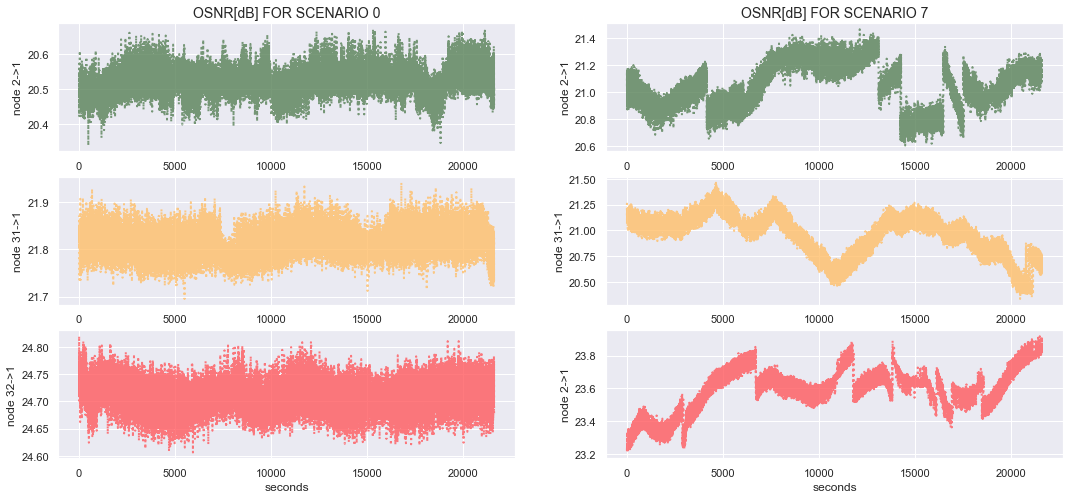

In [430]:
# Normalized-Data Plot
fig, axs = plt.subplots(3,2,figsize=(18,8))
paint = ['#588157', '#ffbf69', '#ff595e']

# SCENARIO 0, PATH 2 -> 1
draw00 = dataset['OSNR[dB] '].iloc[np.where(Y['File'] == 2)[0]]
axs[0,0].plot(range(1,len(draw00)+1), draw00, linestyle='dotted', lw=2, color=paint[0],label='OSNR for red lightpath node[2 -> 1], Scenario 0', alpha=.8) 
axs[0,0].set_title('OSNR[dB] FOR SCENARIO 0', fontsize=14)
axs[0,0].grid(visible = True)
axs[0,0].set(ylabel='node 2->1')

# SCENARIO 0, PATH 3-1 -> 1
draw01 = dataset['OSNR[dB] '].iloc[np.where(Y['File'] == 31)[0]]
axs[1,0].plot(range(1,len(draw01)+1), draw01, linestyle='dotted', lw=2, color=paint[1],label='OSNR for red lightpath node[3-1 -> 1], Scenario 0', alpha=.8) 
axs[1,0].grid(visible = True)
axs[1,0].set(ylabel='node 31->1')

# SCENARIO 0, PATH 3-2 -> 1
draw02 = dataset['OSNR[dB] '].iloc[np.where(Y['File'] == 32)[0]]
axs[2,0].plot(range(1,len(draw02)+1), draw02, linestyle='dotted', lw=2, color=paint[2],label='OSNR for red lightpath node[3-2 -> 1], Scenario 0', alpha=.8) 
axs[2,0].grid(visible = True)
axs[2,0].set(xlabel='seconds', ylabel='node 32->1')

# SCENARIO 7, PATH 2 -> 1
draw22 = dataset['OSNR[dB] '].iloc[np.where(Y['File'] == 702)[0]]
axs[0,1].plot(range(1,len(draw22)+1), draw22, linestyle='dotted', lw=2, color=paint[0],label='OSNR for red lightpath node[2 -> 1], Scenario 0', alpha=.8) 
axs[0,1].grid(visible = True)
axs[0,1].set_title('OSNR[dB] FOR SCENARIO 7', fontsize=14)
axs[0,1].set(ylabel='node 2->1')

# SCENARIO 7, PATH 3-1 -> 1
draw21 = dataset['OSNR[dB] '].iloc[np.where(Y['File'] == 731)[0]]
axs[1,1].plot(range(1,len(draw21)+1), draw21, linestyle='dotted', lw=2, color=paint[1],label='OSNR for red lightpath node[3-1 -> 1], Scenario 0', alpha=.8) 
axs[1,1].grid(visible = True)
axs[1,1].set(ylabel='node 31->1')

# SCENARIO 7, PATH 3-2 -> 1
draw22 = dataset['OSNR[dB] '].iloc[np.where(Y['File'] == 732)[0]]
axs[2,1].plot(range(1,len(draw22)+1), draw22, linestyle='dotted', lw=2, color=paint[2],label='OSNR for red lightpath node[3-2 -> 1], Scenario 0', alpha=.8) 
axs[2,1].grid(visible = True)
axs[2,1].set(xlabel='seconds', ylabel='node 2->1')

plt.show()

### **Using the ORIGINAL data:**

Receive accuracy, runtime and size scores by 3 different classifiers,
and plot them

In [431]:
# Split dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y['GroundTruth'], test_size=0.3)

# Retrieve accuracy, score and runtime for all three classifiers
XGB_score, kNN_score, MLP_score, XGB_runtime, kNN_runtime, MLP_runtime, XGB_size, kNN_size, MLP_size = ML_workaround(X_train, X_test, y_train, y_test)

[21:36:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:37:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:37:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:37:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

**Plot the accuracy per classifier using the original data**

As a result from multiple testings, we can say that generally the MLP model is the least accurate of all,

while XGB and KNN have usually very high accuracy

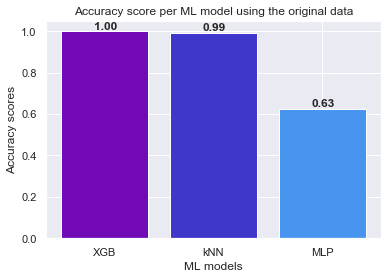

In [432]:
# x-coordinates of left sides of bars 
left = [1, 2, 3]
  
# heights of bars
height = [XGB_score, kNN_score, MLP_score]
  
# labels for bars
tick_label = ['XGB', 'kNN', 'MLP']
  
# plotting a bar chart
plt.bar(left, height, tick_label = tick_label,
        width = 0.8, color = ['#7209b7', '#3f37c9', '#4895ef'])

# write the accuracy of each case on top of the bar
xlocs=[i+1 for i in range(len(height))]
for i, v in enumerate(height):
    plt.text(xlocs[i] - 0.1, v + 0.01, str("{:.2f}".format(v)), fontweight='bold')
  
# naming the x-axis
plt.xlabel('ML models')
# naming the y-axis
plt.ylabel('Accuracy scores')
# plot title
plt.title('Accuracy score per ML model using the original data')
  
# function to show the plot
plt.show()

**Print the runtime of each ML classifier using the original data**

In [433]:
print("The runtime of the XGB classifier is {:.2f}".format(XGB_runtime), "seconds")
print("The runtime of the kNN classifier is {:.2f}".format(kNN_runtime), "seconds")
print("The runtime of the MLP classifier is {:.2f}".format(MLP_runtime), "seconds")

The runtime of the XGB classifier is 49.32 seconds
The runtime of the kNN classifier is 3.66 seconds
The runtime of the MLP classifier is 67.21 seconds


**Plot the runtime per classifier using the original data**

As it can be observed from the results, it can be assumed that the KNN algorithm is by far the fastest, while XGB and MLP tend to have an extremely high processing time with respect to KNN

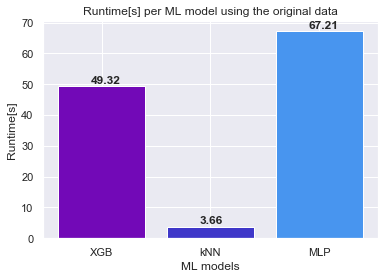

In [434]:
# x-coordinates of left sides of bars 
left = [1, 2, 3]
  
# heights of bars
height = [XGB_runtime, kNN_runtime, MLP_runtime]
  
# labels for bars
tick_label = ['XGB', 'kNN', 'MLP']
  
# plotting a bar chart
plt.bar(left, height, tick_label = tick_label,
        width = 0.8, color = ['#7209b7', '#3f37c9', '#4895ef'])

# write the accuracy of each case on top of the bar
xlocs=[i+1 for i in range(len(height))]
for i, v in enumerate(height):
    plt.text(xlocs[i] - 0.1, v + 1, str("{:.2f}".format(v)), fontweight='bold')
  
# naming the x-axis
plt.xlabel('ML models')
# naming the y-axis
plt.ylabel('Runtime[s]')
# plot title
plt.title('Runtime[s] per ML model using the original data')
  
# function to show the plot
plt.show()

**Print the size of each ML classifier using the original data**

In [435]:
print("The runtime of the XGB classifier is {:.2f}".format(XGB_size * pow(10, -3)), "MB")
print("The runtime of the kNN classifier is {:.2f}".format(kNN_size * pow(10, -3)), "MB")
print("The runtime of the MLP classifier is {:.2f}".format(MLP_size * pow(10, -3)), "MB")

The runtime of the XGB classifier is 202.10 MB
The runtime of the kNN classifier is 79325.42 MB
The runtime of the MLP classifier is 524.49 MB


**Plot the size of the trained model per classifier using the original data**

As it can be observed from the results, it can be assumed that the KNN algorithm is by far the one with the biggest size, while XGB and MLP tend to have an extremely smaller size with respect to KNN

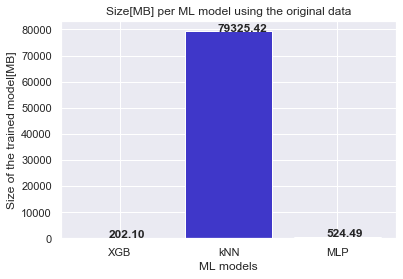

In [436]:
# x-coordinates of left sides of bars 
left = [1, 2, 3]
  
# heights of bars
height = [XGB_size * pow(10, -3), kNN_size * pow(10, -3), MLP_size * pow(10, -3)]
  
# labels for bars
tick_label = ['XGB', 'kNN', 'MLP']
  
# plotting a bar chart
plt.bar(left, height, tick_label = tick_label,
        width = 0.8, color = ['#7209b7', '#3f37c9', '#4895ef'])

# write the accuracy of each case on top of the bar
xlocs=[i+1 for i in range(len(height))]
for i, v in enumerate(height):
    plt.text(xlocs[i] - 0.1, v + 0.01, str("{:.2f}".format(v)), fontweight='bold')
  
# naming the x-axis
plt.xlabel('ML models')
# naming the y-axis
plt.ylabel('Size of the trained model[MB]')
# plot title
plt.title('Size[MB] per ML model using the original data')
  
# function to show the plot
plt.show()

In general, the accuracy is quite high for all the three models.
However, when it comes to the size or the time required to build and test the classifiers, we encounter a trade-off: it can be possible to have high accuracy only having either a small computational time, or a small sized model

### **Using the NORMALIZED data:**

Receive accuracy, runtime and size scores by 3 different classifiers,
and plot them

In [437]:
# Split dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(normalized_X, Y['GroundTruth'], test_size=0.3)

# the ML_workaround function will return score,size and runtime for each classifier used
XGB_score_norm, kNN_score_norm, MLP_score_norm, XGB_runtime_norm, kNN_runtime_norm, MLP_runtime_norm, XGB_size_norm, kNN_size_norm, MLP_size_norm = ML_workaround(X_train, X_test, y_train, y_test)

[21:38:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:39:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:39:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:39:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [438]:
normalized_X

,PK_WL[THZ],LEVEL[dBm],3.0dB WD[nm],CRT WL WL[NM],3.0dB PB[nm],RIPPLE[dB],CROSS TK[L][dB],CROSS TK[R][dB],NOISE[dBm][NBW],OSNR[dB]
0,0.153129,0.508579,-0.465391,0.299599,0.274882,-0.372848,0.937200,0.932319,0.224355,-0.018499
1,0.153129,0.512984,-0.523944,0.340002,0.280726,-0.359917,0.919874,0.916736,0.224654,-0.016432
2,0.153129,0.512984,-0.491996,0.560381,0.232812,-0.410368,0.988422,0.987361,0.219878,-0.010918
3,0.153129,0.512984,-0.491996,0.560381,0.232812,-0.410368,0.988422,0.987361,0.188538,-0.027114
4,0.153129,0.402145,-0.561201,0.479575,0.311115,-0.323854,0.830235,0.824748,0.188538,-0.027114
...,...,...,...,...,...,...,...,...,...,...
519595,-1.291826,-0.394278,2.036414,-1.540563,0.240987,1.704772,-0.398107,-0.413322,-1.213131,1.235465
519596,-1.291826,-0.442724,2.355805,-1.516688,0.221118,1.675995,-0.380028,-0.390702,-1.215817,1.215479
519597,-1.291826,-0.456671,2.302571,-1.553418,0.239817,1.684373,-0.396601,-0.413825,-1.211041,1.232364
519598,-1.291826,-0.389874,2.196109,-1.522198,0.214106,1.687287,-0.374756,-0.382659,-1.214325,1.238567


**Plot the accuracy per classifier using the normalized data**

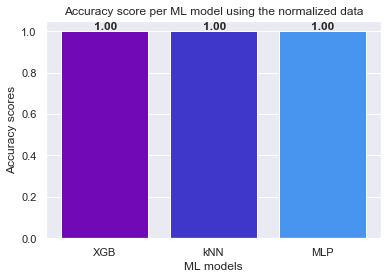

In [439]:
# x-coordinates of left sides of bars 
left = [1, 2, 3]
  
# heights of bars
height = [XGB_score_norm, kNN_score_norm, MLP_score_norm]
  
# labels for bars
tick_label = ['XGB', 'kNN', 'MLP']
  
# plotting a bar chart
plt.bar(left, height, tick_label = tick_label,
        width = 0.8, color = ['#7209b7', '#3f37c9', '#4895ef'])

# write the accuracy of each case on top of the bar
xlocs=[i+1 for i in range(len(height))]
for i, v in enumerate(height):
    plt.text(xlocs[i] - 0.1, v + 0.01, str("{:.2f}".format(v)), fontweight='bold')
     
# naming the x-axis
plt.xlabel('ML models')
# naming the y-axis
plt.ylabel('Accuracy scores')
# plot title
plt.title('Accuracy score per ML model using the normalized data')
  
# function to show the plot
plt.show()

As it can be seen, using a normalized dataset improves the quality of our classifier leading to accuracy score almost perfect.

**Print the runtime of each ML classifier using the normalized data**

In [440]:
print("The runtime of the XGB classifier is {:.2f}".format(XGB_runtime_norm), "seconds")
print("The runtime of the kNN classifier is {:.2f}".format(kNN_runtime_norm), "seconds")
print("The runtime of the MLP classifier is {:.2f}".format(MLP_runtime_norm), "seconds")

The runtime of the XGB classifier is 51.89 seconds
The runtime of the kNN classifier is 21.29 seconds
The runtime of the MLP classifier is 47.12 seconds


**Plot the runtime per classifier using the normalized data**

As it can be observed from the results, it can be assumed that the KNN algorithm is by far the fastest, while XGB and MLP tend to have an extremely high processing time with respect to KNN

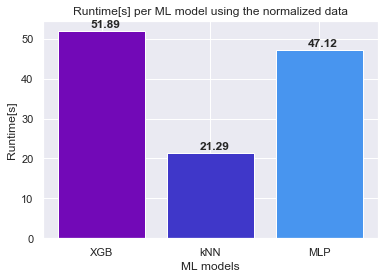

In [441]:
# x-coordinates of left sides of bars 
left = [1, 2, 3]
  
# heights of bars
height = [XGB_runtime_norm, kNN_runtime_norm, MLP_runtime_norm]
  
# labels for bars
tick_label = ['XGB', 'kNN', 'MLP']
  
# plotting a bar chart
plt.bar(left, height, tick_label = tick_label,
        width = 0.8, color = ['#7209b7', '#3f37c9', '#4895ef'])

# write the accuracy of each case on top of the bar
xlocs=[i+1 for i in range(len(height))]
for i, v in enumerate(height):
    plt.text(xlocs[i] - 0.1, v + 1, str("{:.2f}".format(v)), fontweight='bold')
  
# naming the x-axis
plt.xlabel('ML models')
# naming the y-axis
plt.ylabel('Runtime[s]')
# plot title
plt.title('Runtime[s] per ML model using the normalized data')
  
# function to show the plot
plt.show()

**Print the size of each ML classifier using the normalized data**

In [442]:
print("The runtime of the XGB classifier is {:.2f}".format(XGB_size_norm * pow(10, -3)), "MB")
print("The runtime of the kNN classifier is {:.2f}".format(kNN_size_norm * pow(10, -3)), "MB")
print("The runtime of the MLP classifier is {:.2f}".format(MLP_size_norm * pow(10, -3)), "MB")

The runtime of the XGB classifier is 190.11 MB
The runtime of the kNN classifier is 67162.08 MB
The runtime of the MLP classifier is 519.64 MB


**Plot the size of the trained model per classifier using the normalized data**

As it can be observed from the results, it can be assumed that the KNN algorithm is by far the one with the biggest size, while XGB and MLP tend to have an extremely smaller size with respect to KNN

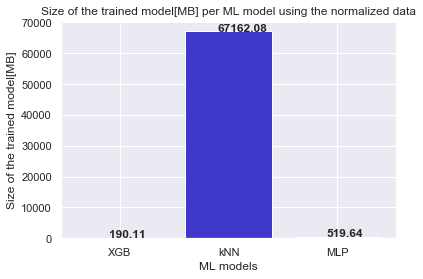

In [443]:
# x-coordinates of left sides of bars 
left = [1, 2, 3]
  
# heights of bars
height = [XGB_size_norm * pow(10, -3), kNN_size_norm * pow(10, -3), MLP_size_norm * pow(10, -3)]
  
# labels for bars
tick_label = ['XGB', 'kNN', 'MLP']
  
# plotting a bar chart
plt.bar(left, height, tick_label = tick_label,
        width = 0.8, color = ['#7209b7', '#3f37c9', '#4895ef'])

# write the accuracy of each case on top of the bar
xlocs=[i+1 for i in range(len(height))]
for i, v in enumerate(height):
    plt.text(xlocs[i] - 0.1, v + 0.01, str("{:.2f}".format(v)), fontweight='bold')
  
# naming the x-axis
plt.xlabel('ML models')
# naming the y-axis
plt.ylabel('Size of the trained model[MB]')
# plot title
plt.title('Size of the trained model[MB] per ML model using the normalized data')
  
# function to show the plot
plt.show()

## Examine what is the impact of window duration and windows spacing on the performance

### **Keeping the window spacing still, change the window duration**

Then evaluate each classifier's scores for each window duration.
The spacing is mantained constant while the windolwength is changed and the results are analyzed considering the three different classifiers.

In [444]:
# Keep the names of folders produced to be used by the ML part
adjusted_data_foldernames_wlen = [] 

# fixed window spacing
spacing=10
# list of window durations exploited
wlen = [10, 30, 60, 120, 300, 900, 1800, 3600]

# for every file in the list_of_files retrieved:
for filename in list_of_files: 
    # iterating in the window duration list
    for windowlength in wlen:
        foldername = 'Project_4_data_adjusted' + '_sp' + str(spacing) + '_w' + str(windowlength)
        
        # Avoid multiple writtings of the same folder name
        if foldername not in adjusted_data_foldernames_wlen:
            adjusted_data_foldernames_wlen.append(foldername)
            
        # create a resampled dataset of specified windowlength and spacing, and save it in filename
        create_window_dataset(filename, foldername, windowlength, spacing)

knn_accuracy_wlen, xgbc_accuracy_wlen, mlp_accuracy_wlen = evaluate_adjusted_dataset(adjusted_data_foldernames_wlen)

Creating windows dataset from file Scenario_0_monitor_node_1_preamp_lpth_2_1.dat (window length=10; spacing=10)
Last window reached. Current window (with length 10) would start with ID 21600, but last feature ID is 21599

Creating windows dataset from file Scenario_0_monitor_node_1_preamp_lpth_2_1.dat (window length=30; spacing=10)
Last window reached. Current window (with length 30) would start with ID 21580, but last feature ID is 21599

Creating windows dataset from file Scenario_0_monitor_node_1_preamp_lpth_2_1.dat (window length=60; spacing=10)
Last window reached. Current window (with length 60) would start with ID 21550, but last feature ID is 21599

Creating windows dataset from file Scenario_0_monitor_node_1_preamp_lpth_2_1.dat (window length=120; spacing=10)
Last window reached. Current window (with length 120) would start with ID 21490, but last feature ID is 21599

Creating windows dataset from file Scenario_0_monitor_node_1_preamp_lpth_2_1.dat (window length=300; spacing=1

In [445]:
knn_accuracy_wlen

{'sp10_w10': 1.0,
 'sp10_w30': 1.0,
 'sp10_w60': 1.0,
 'sp10_w120': 1.0,
 'sp10_w300': 0.9999348661499381,
 'sp10_w900': 1.0,
 'sp10_w1800': 1.0,
 'sp10_w3600': 1.0}

In [446]:
xgbc_accuracy_wlen

{'sp10_w10': 0.9999725048116581,
 'sp10_w30': 0.9999724783266822,
 'sp10_w60': 0.999972432804962,
 'sp10_w120': 0.9999723451327434,
 'sp10_w300': 0.9999720826353993,
 'sp10_w900': 0.999942512216154,
 'sp10_w1800': 0.999969951923077,
 'sp10_w3600': 0.9998677904478598}

In [447]:
mlp_accuracy_wlen

{'sp10_w10': 1.0,
 'sp10_w30': 1.0,
 'sp10_w60': 1.0,
 'sp10_w120': 1.0,
 'sp10_w300': 0.9999348661499381,
 'sp10_w900': 1.0,
 'sp10_w1800': 1.0,
 'sp10_w3600': 1.0}

**Plot the accuracy per classifier as the windowlength increases with still spacing**

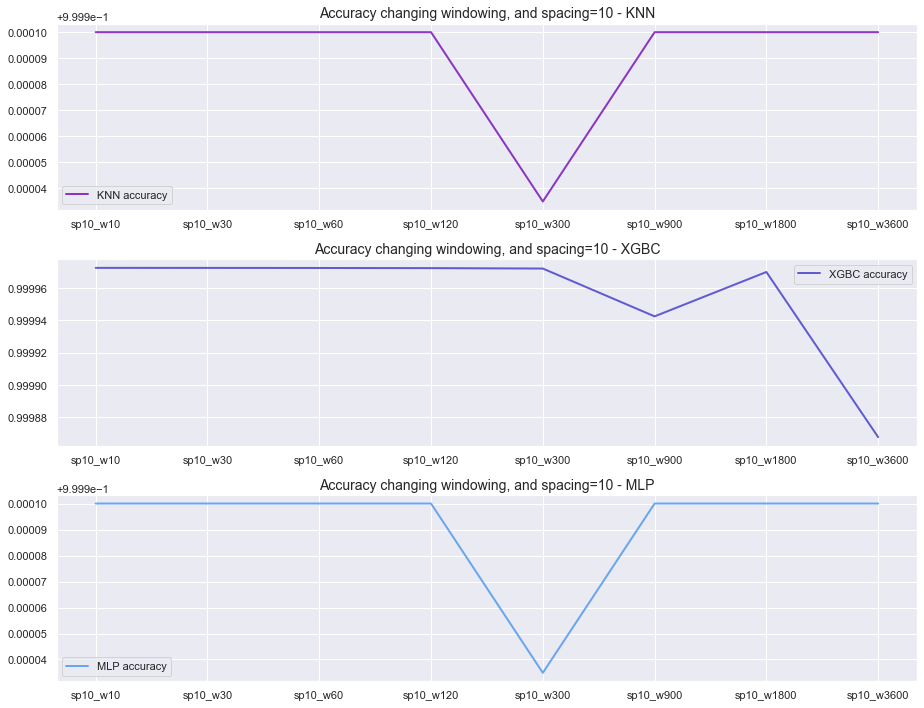

In [448]:
# Accuracy per Windowing Plot 
fig, ax = plt.subplots(3,figsize=(13,10)) 
 
paint = ['#7209b7', '#3f37c9', '#4895ef'] 
x = list(knn_accuracy_wlen.keys()) 
 
# KNN PERFORMANCES 
ax[0].set_title('Accuracy changing windowing, and spacing={} - KNN'.format(spacing), fontsize=14) 
ax[0].plot(x, list(knn_accuracy_wlen.values()), lw=2, color=paint[0], label='KNN accuracy', alpha=.8) 
ax[0].legend() 

# XGBC PERFORMANCES
ax[1].set_title('Accuracy changing windowing, and spacing={} - XGBC'.format(spacing), fontsize=14) 
ax[1].plot(x, list(xgbc_accuracy_wlen.values()), lw=2, color=paint[1],label='XGBC accuracy', alpha=.8) 
ax[1].legend() 
 
# MLP PERFORMANCES
ax[2].set_title('Accuracy changing windowing, and spacing={} - MLP'.format(spacing), fontsize=14) 
ax[2].plot(x, list(mlp_accuracy_wlen.values()), lw=2, color=paint[2],label='MLP accuracy', alpha=.8) 
ax[2].legend() 
 
 
fig.tight_layout()

**Name the folder, which provides the best accuracy score per classifier**

In [449]:
print("The best accuracy for the k-NN classifier is obtained under the parameters {} - Maximum accuracy score of k-NN: {:.2f}".format(max(knn_accuracy_wlen, key=knn_accuracy_wlen.get), knn_accuracy_wlen[max(knn_accuracy_wlen, key=knn_accuracy_wlen.get)]))
print("The best accuracy for the XGB classifier is obtained under the parameters {} - Maximum accuracy score of XGB: {:.2f}".format(max(xgbc_accuracy_wlen, key=xgbc_accuracy_wlen.get), xgbc_accuracy_wlen[max(xgbc_accuracy_wlen, key=knn_accuracy_wlen.get)]))
print("The best accuracy for the MLP classifier is obtained under the parameters {} - Maximum accuracy score of MLP: {:.2f}".format(max(mlp_accuracy_wlen, key=mlp_accuracy_wlen.get), mlp_accuracy_wlen[max(mlp_accuracy_wlen, key=mlp_accuracy_wlen.get)]))


The best accuracy for the k-NN classifier is obtained under the parameters sp10_w10 - Maximum accuracy score of k-NN: 1.00
The best accuracy for the XGB classifier is obtained under the parameters sp10_w10 - Maximum accuracy score of XGB: 1.00
The best accuracy for the MLP classifier is obtained under the parameters sp10_w10 - Maximum accuracy score of MLP: 1.00


**Best three parameters' combination**

Retrieve the folders containing the 3 best parameters' combination with fixed spacing that provides the best accuracy score per classifier

In [450]:
# Initialize one array per classifier to store the best folders
best_folders_kNN = []
best_folders_XGB = []
best_folders_MLP = []

# Retrieve the 3 best parameters' combination per classifier
best_parameters_kNN = nlargest(3, knn_accuracy_wlen, key = knn_accuracy_wlen.get)
best_parameters_XGB = nlargest(3, xgbc_accuracy_wlen, key = xgbc_accuracy_wlen.get)
best_parameters_MLP = nlargest(3, mlp_accuracy_wlen, key = mlp_accuracy_wlen.get)


for i in range(len(best_parameters_kNN)):
    # Synthesize the foldername per classifier joining the strings:
    # "Project", "4", "adjusted" and window duration and spacing combintation

    foldername_components_kNN = ['Project', '4', 'data', 'adjusted', best_parameters_kNN[i]]
    best_folername_kNN = "_".join(foldername_components_kNN)
    best_folders_kNN.append(best_folername_kNN)

    foldername_components_XGB = ['Project', '4', 'data', 'adjusted', best_parameters_XGB[i]]
    best_folername_XGB = "_".join(foldername_components_XGB)
    best_folders_XGB.append(best_folername_XGB)

    foldername_components_MLP = ['Project', '4', 'data', 'adjusted', best_parameters_MLP[i]]
    best_foldername_MLP = "_".join(foldername_components_MLP)
    best_folders_MLP.append(best_foldername_MLP)


### **Keeping the window duration still, change the window spacing**

Then evaluate each classifier's accuracy score for each spacing.
The dual procedure of mantaining the spacing costant is done in the followings.
Then the results of having a windowlength = 60 s and increasing spacing are analyzed with the three classifiers.

In [451]:
# Keep the names of folders produced to be used by the ML part
adjusted_data_foldernames_spacing = [] 

# fixed window duration
windowlength=60
# list of window spacings exploited
sp = [5 ,15, 30, 45, 60, 75, 90, 150]

# for every file in the list_of_files retrieved:
for filename in list_of_files: 
    # iterating in the window spacing list
     for spacing in sp:
        foldername = 'Project_4_data_adjusted' + '_sp' + str(spacing) + '_w' + str(windowlength)
        
        # Avoid multiple writtings of the same folder name
        if foldername not in adjusted_data_foldernames_spacing:
            adjusted_data_foldernames_spacing.append(foldername)
            
        # create a resampled dataset of specified windowlength and spacing, and save it in filename
        create_window_dataset(filename, foldername, windowlength, spacing)

knn_accuracy_sp, xgbc_accuracy_sp, mlp_accuracy_sp = evaluate_adjusted_dataset(adjusted_data_foldernames_spacing)

Creating windows dataset from file Scenario_0_monitor_node_1_preamp_lpth_2_1.dat (window length=60; spacing=5)
Last window reached. Current window (with length 60) would start with ID 21545, but last feature ID is 21599

Creating windows dataset from file Scenario_0_monitor_node_1_preamp_lpth_2_1.dat (window length=60; spacing=15)
Last window reached. Current window (with length 60) would start with ID 21555, but last feature ID is 21599

Creating windows dataset from file Scenario_0_monitor_node_1_preamp_lpth_2_1.dat (window length=60; spacing=30)
Last window reached. Current window (with length 60) would start with ID 21570, but last feature ID is 21599

Creating windows dataset from file Scenario_0_monitor_node_1_preamp_lpth_2_1.dat (window length=60; spacing=45)
Last window reached. Current window (with length 60) would start with ID 21555, but last feature ID is 21599

Creating windows dataset from file Scenario_0_monitor_node_1_preamp_lpth_2_1.dat (window length=60; spacing=60)
L

**Plot the accuracy per classifier as the windowlength increases with still spacing**

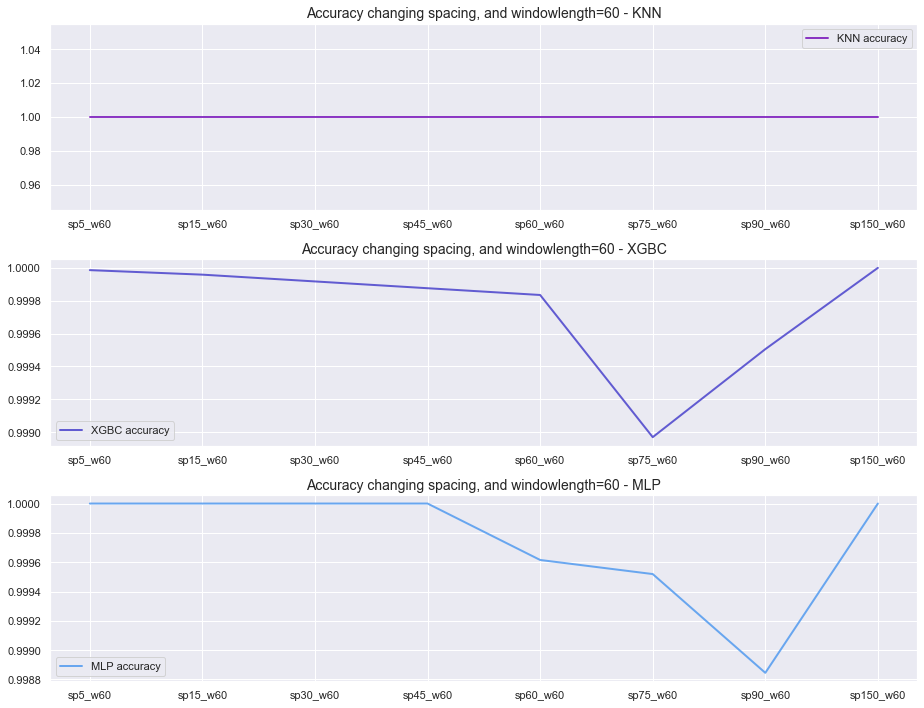

In [452]:
# Accuracy per Windowing Plot 
fig, ax = plt.subplots(3,figsize=(13,10)) 
 
paint = ['#7209b7', '#3f37c9', '#4895ef'] 
x = list(knn_accuracy_sp.keys()) 
 
# KNN PERFORMANCES 
ax[0].set_title('Accuracy changing spacing, and windowlength={} - KNN'.format(windowlength), fontsize=14) 
ax[0].plot(x, list(knn_accuracy_sp.values()), lw=2, color=paint[0], label='KNN accuracy', alpha=.8) 
ax[0].legend() 

# XGBC PERFORMANCES
ax[1].set_title('Accuracy changing spacing, and windowlength={} - XGBC'.format(windowlength), fontsize=14) 
ax[1].plot(x, list(xgbc_accuracy_sp.values()), lw=2, color=paint[1],label='XGBC accuracy', alpha=.8) 
ax[1].legend() 
 
# MLP PERFORMANCES
ax[2].set_title('Accuracy changing spacing, and windowlength={} - MLP'.format(windowlength), fontsize=14) 
ax[2].plot(x, list(mlp_accuracy_sp.values()), lw=2, color=paint[2],label='MLP accuracy', alpha=.8) 
ax[2].legend() 
 
 
fig.tight_layout()

**Name the folder, which provides the best accuracy score per classifier**

In [453]:
print("The best accuracy for the k-NN classifier is obtained under the parameters {} - Maximum accuracy score of k-NN: {:.2f}".format(max(knn_accuracy_sp, key=knn_accuracy_sp.get), knn_accuracy_sp[max(knn_accuracy_sp, key=knn_accuracy_sp.get)]))
print("The best accuracy for the XGB classifier is obtained under the parameters {} - Maximum accuracy score of XGB: {:.2f}".format(max(xgbc_accuracy_sp, key=xgbc_accuracy_sp.get), xgbc_accuracy_sp[max(xgbc_accuracy_sp, key=knn_accuracy_sp.get)]))
print("The best accuracy for the MLP classifier is obtained under the parameters {} - Maximum accuracy score of MLP: {:.2f}".format(max(mlp_accuracy_sp, key=mlp_accuracy_sp.get), mlp_accuracy_sp[max(mlp_accuracy_sp, key=mlp_accuracy_sp.get)]))


The best accuracy for the k-NN classifier is obtained under the parameters sp5_w60 - Maximum accuracy score of k-NN: 1.00
The best accuracy for the XGB classifier is obtained under the parameters sp150_w60 - Maximum accuracy score of XGB: 1.00
The best accuracy for the MLP classifier is obtained under the parameters sp5_w60 - Maximum accuracy score of MLP: 1.00


**Retrieve the folders containing the 3 best parameters'combination with fixed windowlength that provides the best accuracy score per classifier**

With the function "nlargest" are retrieved the three best parameters combination per classifier.

In [454]:
# Retrieve the 3 best parameters' combination per classifier
best_parameters_kNN = nlargest(3, knn_accuracy_sp, key = knn_accuracy_sp.get)
best_parameters_XGB = nlargest(3, xgbc_accuracy_sp, key = xgbc_accuracy_sp.get)
best_parameters_MLP = nlargest(3, mlp_accuracy_sp, key = mlp_accuracy_sp.get)


for i in range(len(best_parameters_kNN)):
    # Synthesize the foldername per classifier joining the strings:
    # "Project", "4", "adjusted" and window duration and spacing combintation

    foldername_components_kNN = ['Project', '4', 'data', 'adjusted', best_parameters_kNN[i]]
    best_folername_kNN = "_".join(foldername_components_kNN)
    best_folders_kNN.append(best_folername_kNN)

    foldername_components_XGB = ['Project', '4', 'data', 'adjusted', best_parameters_XGB[i]]
    best_folername_XGB = "_".join(foldername_components_XGB)
    best_folders_XGB.append(best_folername_XGB)

    foldername_components_MLP = ['Project', '4', 'data', 'adjusted', best_parameters_MLP[i]]
    best_foldername_MLP = "_".join(foldername_components_MLP)
    best_folders_MLP.append(best_foldername_MLP)


**Then print the 6 best combinations that provides the best accuracy score per classifier**

In [455]:
print("kNN")
print(best_folders_kNN)
print("XGB")
print(best_folders_XGB)
print("MLP")
print(best_folders_MLP)

kNN
['Project_4_data_adjusted_sp10_w10', 'Project_4_data_adjusted_sp10_w30', 'Project_4_data_adjusted_sp10_w60', 'Project_4_data_adjusted_sp5_w60', 'Project_4_data_adjusted_sp15_w60', 'Project_4_data_adjusted_sp30_w60']
XGB
['Project_4_data_adjusted_sp10_w10', 'Project_4_data_adjusted_sp10_w30', 'Project_4_data_adjusted_sp10_w60', 'Project_4_data_adjusted_sp150_w60', 'Project_4_data_adjusted_sp5_w60', 'Project_4_data_adjusted_sp15_w60']
MLP
['Project_4_data_adjusted_sp10_w10', 'Project_4_data_adjusted_sp10_w30', 'Project_4_data_adjusted_sp10_w60', 'Project_4_data_adjusted_sp5_w60', 'Project_4_data_adjusted_sp15_w60', 'Project_4_data_adjusted_sp30_w60']


## **Feature Removal**

### Randomly pick one of the best folders generated in the previous step to perform the feature removal operation

In [456]:
#concatentate the three arrays
best_folder = best_folders_kNN + best_folders_XGB + best_folders_MLP

# randomly pick one
random_best_folder = random.choice(best_folder)

print(random_best_folder)

Project_4_data_adjusted_sp10_w30


**Use the folder chosen to create a dataset and normalize it**

In [457]:
#Retrieve the available files for analysis
path = r'./' + random_best_folder + '/'
list_of_adjusted_files = retrieve_files(path)

# Create datasets, append GroundTruth & normalizes the feature values per light path per scenario
dataset, X, Y = create_dataset(list_of_adjusted_files, path, skip=False)

# Create also a normalized version of the data
normalized_X = normalize_dataset(X)

There are 27 files present
['Scenario_0_monitor_node_1_preamp_lpth_2_1_sp10_w30.dat', 'Scenario_0_monitor_node_1_preamp_lpth_3-1_1_sp10_w30.dat', 'Scenario_0_monitor_node_1_preamp_lpth_3-2_1_sp10_w30.dat', 'Scenario_1_monitor_node_1_preamp_lpth_2_1_sp10_w30.dat', 'Scenario_1_monitor_node_1_preamp_lpth_3-1_1_sp10_w30.dat', 'Scenario_1_monitor_node_1_preamp_lpth_3-2_1_sp10_w30.dat', 'Scenario_2_monitor_node_1_preamp_lpth_2_1_sp10_w30.dat', 'Scenario_2_monitor_node_1_preamp_lpth_3-1_1_sp10_w30.dat', 'Scenario_2_monitor_node_1_preamp_lpth_3-2_1_sp10_w30.dat', 'Scenario_3_monitor_node_1_preamp_lpth_2_1_sp10_w30.dat', 'Scenario_3_monitor_node_1_preamp_lpth_3-1_1_sp10_w30.dat', 'Scenario_3_monitor_node_1_preamp_lpth_3-2_1_sp10_w30.dat', 'Scenario_4_monitor_node_1_preamp_lpth_2_1_sp10_w30.dat', 'Scenario_4_monitor_node_1_preamp_lpth_3-1_1_sp10_w30.dat', 'Scenario_4_monitor_node_1_preamp_lpth_3-2_1_sp10_w30.dat', 'Scenario_5_monitor_node_1_preamp_lpth_2_1_sp10_w30.dat', 'Scenario_5_monitor_node

**In each iteration, remove a feature from the dataset and re-evaluate the scrores of each classifier. This way, it can be identified the importance of each feature in the prediction model**

In [458]:
# df contains 14 columns but the first one is DATA and the last two are relevant for the classification algorithms  
# auxiliary dataframe to use for eliminating each column each time 
 
auxiliary_dataframe = pd.DataFrame() 
auxiliary_dataframe = normalized_X 
 
# dictionary which is saved the name of the column deleted and the performances obtained 
mlp_performances = {} 
xgbc_performances = {} 
knn_performances = {} 
 
for (colname,colval) in auxiliary_dataframe.iteritems(): 
   
    # for each cycle, remove a column from the dataset
    auxiliary_dataframe.drop(colname, axis = 1, inplace = True) 
    print("Removing column :",colname)     
 
    # shuffle, and split the dataset(without the column) in train and test
    X_train, X_test, y_train, y_test = train_test_split(auxiliary_dataframe, Y['GroundTruth'], test_size=0.3) 
     
    # MLP model
    MLP_score, MLP_runtime, MLP_size = MLP_classifier(X_train, X_test, y_train, y_test)   
     
    # XGB model
    XGB_score, XGB_runtime, XGB_size = XGB_classifier(X_train, y_train) 
 
    # KNN model
    kNN_score, kNN_runtime, kNN_size = kNN_classifier(X_train, X_test, y_train, y_test) 
 
    # Retrieve scores
    knn_performances[colname] = kNN_score 
    xgbc_performances[colname] = XGB_score 
    mlp_performances[colname] = MLP_score 
 
    print() 
 
    # Reinserting the removed column 
    auxiliary_dataframe[colname] = colval

Removing column : LEVEL[dBm]
Iteration 1, loss = 0.08584636
Iteration 2, loss = 0.00140187
Iteration 3, loss = 0.00076716
Iteration 4, loss = 0.00046622
Iteration 5, loss = 0.00017145
Iteration 6, loss = 0.00013253
Iteration 7, loss = 0.00010804
Iteration 8, loss = 0.00009552
Iteration 9, loss = 0.00008828
Iteration 10, loss = 0.00008214
Score of MLP classifier is: 1.00
[21:45:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:45:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:45:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objectiv

**Merge the dictionaries of best parameters' combination and reconstruct the foldernames, so they are used as keys to retrieve the total accuracy per classifier needed to plot**

In [459]:
# Merge the dictionaries of best parameters'combination
best_accuracy = {**knn_accuracy_wlen, **xgbc_accuracy_wlen, **mlp_accuracy_wlen, **knn_accuracy_sp, **xgbc_accuracy_sp, **mlp_accuracy_sp}

# Keys in this dictionary is the best parameters'combination and will be used to reconstruct the foldername
# and then substituted by those
key_list = list(best_accuracy.keys())

for key in key_list:
    # Synthesize the foldername per classifier joining the strings:
    # "Project", "4", "adjusted" and window duration and spacing combintation

    foldername_components = ['Project', '4', 'data', 'adjusted', key]
    best_folername = "_".join(foldername_components)

    # Add the foldername constructed accompanied with the respected accuracy score in the dictionary
    best_accuracy[best_folername] = best_accuracy[key]
    # and then remove the no longer wanted key, which existed originally
    del best_accuracy[key]

print(best_accuracy)

{'Project_4_data_adjusted_sp10_w10': 1.0, 'Project_4_data_adjusted_sp10_w30': 1.0, 'Project_4_data_adjusted_sp10_w60': 1.0, 'Project_4_data_adjusted_sp10_w120': 1.0, 'Project_4_data_adjusted_sp10_w300': 0.9999348661499381, 'Project_4_data_adjusted_sp10_w900': 1.0, 'Project_4_data_adjusted_sp10_w1800': 1.0, 'Project_4_data_adjusted_sp10_w3600': 1.0, 'Project_4_data_adjusted_sp5_w60': 1.0, 'Project_4_data_adjusted_sp15_w60': 1.0, 'Project_4_data_adjusted_sp30_w60': 1.0, 'Project_4_data_adjusted_sp45_w60': 1.0, 'Project_4_data_adjusted_sp60_w60': 0.9996150885296382, 'Project_4_data_adjusted_sp75_w60': 0.9995189995189995, 'Project_4_data_adjusted_sp90_w60': 0.9988452655889145, 'Project_4_data_adjusted_sp150_w60': 1.0}


**Plot the performance per classifier when all features are present vs when one feature is missing per iteration**

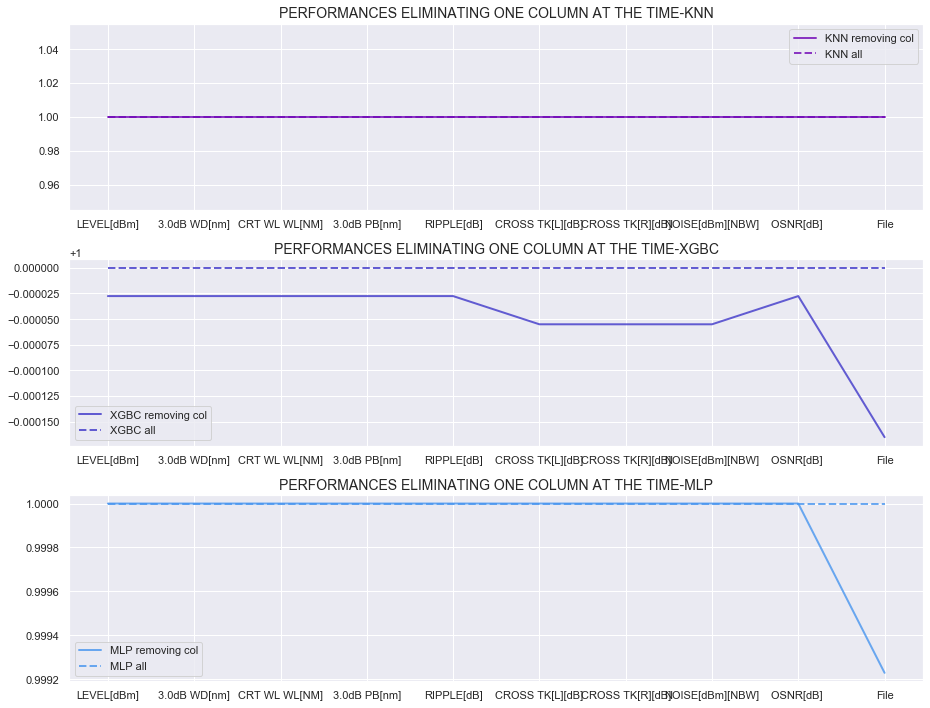

In [460]:
# Normalized-Data Plot 
fig, ax = plt.subplots(3,figsize=(13,10)) 
 
paint = ['#7209b7', '#3f37c9', '#4895ef'] 
x = list(knn_performances.keys()) 
 
# KNN PERFORMANCES 
ax[0].set_title('PERFORMANCES ELIMINATING ONE COLUMN AT THE TIME-KNN', fontsize=14) 
ax[0].plot(x, list(knn_performances.values()), lw=2, color=paint[0], label='KNN removing col', alpha=.8) 
ax[0].plot(x, [best_accuracy[random_best_folder]]*len(x), linestyle='--', lw=2, color=paint[0], label='KNN all', alpha=.8) 
ax[0].legend() 
 
ax[1].set_title('PERFORMANCES ELIMINATING ONE COLUMN AT THE TIME-XGBC', fontsize=14) 
ax[1].plot(x, list(xgbc_performances.values()), lw=2, color=paint[1],label='XGBC removing col', alpha=.8) 
ax[1].plot(x, [best_accuracy[random_best_folder]]*len(x), linestyle='--', lw=2, color=paint[1], label='XGBC all', alpha=.8) 
ax[1].legend() 
 
ax[2].set_title('PERFORMANCES ELIMINATING ONE COLUMN AT THE TIME-MLP', fontsize=14) 
ax[2].plot(x, list(mlp_performances.values()), lw=2, color=paint[2],label='MLP removing col', alpha=.8) 
ax[2].plot(x, [best_accuracy[random_best_folder]]*len(x), linestyle='--', lw=2, color=paint[2], label='MLP all', alpha=.8) 
ax[2].legend() 
 
 
fig.tight_layout()

In the above quoted plotes, the parts of the straight line that are located either below or aboved the dashed one, indicate that the feature removed is important for the classifier, since the accuracy score is affected. In case the accuracy is degrading, means that the respected feature is helpful for the classifier to make a correct prediction. In the opposite case, the removed feature is causing mispredictions and a possible absence from the dataset may be beneficial for the classifier model.

**Name the features, whose absence causes the worse accuracy score per classifier**

In [461]:
print("The most important feature for the k-NN classifier is {} - Minimum accuracy score of k-NN: {:.2f}".format(min(knn_performances, key=knn_performances.get), knn_performances[min(knn_performances, key=knn_performances.get)]))
print("The most important feature for the XGB classifier is {} - Minimum accuracy score of XGB: {:.2f}".format(min(xgbc_performances, key=xgbc_performances.get), xgbc_performances[min(xgbc_performances, key=knn_performances.get)]))
print("The most important feature for the MLP classifier is {} - Minimum accuracy score of MLP: {:.2f}".format(min(mlp_performances, key=mlp_performances.get), mlp_performances[min(mlp_performances, key=mlp_performances.get)]))


The most important feature for the k-NN classifier is LEVEL[dBm] - Minimum accuracy score of k-NN: 1.00
The most important feature for the XGB classifier is File - Minimum accuracy score of XGB: 1.00
The most important feature for the MLP classifier is File - Minimum accuracy score of MLP: 1.00


**Name the features, whose absence causes the best accuracy score per classifier**

In [462]:
print("The less important feature for the k-NN classifier is {} - Maximum accuracy score of k-NN: {:.2f}".format(max(knn_performances, key=knn_performances.get), knn_performances[max(knn_performances, key=knn_performances.get)]))
print("The less important feature for the XGB classifier is {} - Maximum accuracy score of XGB: {:.2f}".format(max(xgbc_performances, key=xgbc_performances.get), xgbc_performances[max(xgbc_performances, key=knn_performances.get)]))
print("The less important feature for the MLP classifier is {} - Maximum accuracy score of MLP: {:.2f}".format(max(mlp_performances, key=mlp_performances.get), mlp_performances[max(mlp_performances, key=mlp_performances.get)]))


The less important feature for the k-NN classifier is LEVEL[dBm] - Maximum accuracy score of k-NN: 1.00
The less important feature for the XGB classifier is 3.0dB WD[nm] - Maximum accuracy score of XGB: 1.00
The less important feature for the MLP classifier is LEVEL[dBm] - Maximum accuracy score of MLP: 1.00


**Keep the features that cause degradation to the accuracy score per classifier (so they are the most important)**

In [463]:
# The threshold is taken from the accuracy score of the randomly selected folder
thres = best_accuracy[random_best_folder]

improved_knn = []
improved_xgbc = []
improved_mlp = []

for key_knn, val_knn, key_xgbc, val_xgbc, key_mlp, val_mlp in \
    zip(list(knn_performances.keys()), list(knn_performances.values()), list(xgbc_performances.keys()), list(xgbc_performances.values()), list(mlp_performances.keys()), list(mlp_performances.values())):

    # if the value of the feature is below the threshold, remove this feature
    if(val_knn <= thres):
        improved_knn.append(key_knn)
    if(val_xgbc <= thres):
        improved_xgbc.append(key_xgbc)
    if(val_mlp <= thres):
        improved_mlp.append(key_mlp)

# Create new datasets, including only the values of the remaining features
data_KNN = X[improved_knn]
data_XGB = X[improved_xgbc]
data_MLP = X[improved_mlp]


**Evaluate the accuracy score of each classifier using for each one the personalized features produced in the previous cell**

In [464]:
if data_XGB.empty:
    print("There are no features that increase the accuracy score of XGB classifier!")

else:
    # Split dataset in train and test
    X_train, X_test, y_train, y_test = train_test_split(data_XGB, Y['GroundTruth'], random_state=24, test_size=0.3)

    # XGB Classifier
    XGB_score, XGB_runtime, XGB_size = XGB_classifier(X_train, y_train)

if data_KNN.empty:
    print("There are no features that increase the accuracy score of k-NN classifier!")

else:
    # Split dataset in train and test
    X_train, X_test, y_train, y_test = train_test_split(data_KNN, Y['GroundTruth'], random_state=24, test_size=0.3)

    # KNN Classifier
    kNN_score, kNN_runtime, kNN_size = kNN_classifier(X_train, X_test, y_train, y_test)

if data_MLP.empty:
    print("There are no features that increase the accuracy score of MLP classifier!")

else:
    # Split dataset in train and test
    X_train, X_test, y_train, y_test = train_test_split(data_MLP, Y['GroundTruth'], random_state=24, test_size=0.3)

    # MLP Classifier
    MLP_score, MLP_runtime, MLP_size = MLP_classifier(X_train, X_test, y_train, y_test)

[21:46:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:46:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:46:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:46:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

**Remove the 2 features that increase the most the accuracy score per classifier**

In [465]:
# For every classifier's performance dictionary, first sort based on values from max to min
sorted_knn_performances = {val[0] : val[1] for val in sorted(knn_performances.items(), key = lambda x: (-x[1], x[0]))}
sorted_xgbc_performances = {val[0] : val[1] for val in sorted(xgbc_performances.items(), key = lambda x: (-x[1], x[0]))}
sorted_mlp_performances = {val[0] : val[1] for val in sorted(mlp_performances.items(), key = lambda x: (-x[1], x[0]))}

# Then remove the 2 features, whose presence increase the classifier performance the most (so they are the less important)

# k-NN
print("Removing", list(sorted_knn_performances.keys())[0], "for k-NN classifier")
del sorted_knn_performances[list(sorted_knn_performances.keys())[0]]

print("Removing", list(sorted_knn_performances.keys())[0], "for k-NN classifier")
del sorted_knn_performances[list(sorted_knn_performances.keys())[0]]

# XGB
print("Removing", list(sorted_xgbc_performances.keys())[0], "for XGB classifier")
del sorted_xgbc_performances[list(sorted_xgbc_performances.keys())[0]]

print("Removing", list(sorted_xgbc_performances.keys())[0], "for XGB classifier")
del sorted_xgbc_performances[list(sorted_xgbc_performances.keys())[0]]

# MLP
print("Removing", list(sorted_mlp_performances.keys())[0], "for MLP classifier")
del sorted_mlp_performances[list(sorted_mlp_performances.keys())[0]]

print("Removing", list(sorted_mlp_performances.keys())[0], "for MLP classifier")
del sorted_mlp_performances[list(sorted_mlp_performances.keys())[0]]

# Create new datasets, including only the values of the remaining features
data_KNN = X[sorted_knn_performances]
data_XGB = X[sorted_xgbc_performances]
data_MLP = X[sorted_mlp_performances]

Removing 3.0dB PB[nm] for k-NN classifier
Removing 3.0dB WD[nm] for k-NN classifier
Removing 3.0dB WD[nm] for XGB classifier
Removing OSNR[dB]  for XGB classifier
Removing 3.0dB PB[nm] for MLP classifier
Removing 3.0dB WD[nm] for MLP classifier


**Evaluate the accuracy score of each classifier using for each one the personalized features produced in the previous cell**

In [466]:
# Split dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(data_XGB, Y['GroundTruth'], random_state=24, test_size=0.3)

# XGB Classifier
XGB_score, XGB_runtime, XGB_size = XGB_classifier(X_train, y_train)
# Split dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(data_KNN, Y['GroundTruth'], random_state=24, test_size=0.3)

# KNN Classifier
kNN_score, kNN_runtime, kNN_size = kNN_classifier(X_train, X_test, y_train, y_test)

# Split dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(data_MLP, Y['GroundTruth'], random_state=24, test_size=0.3)

# MLP Classifier
MLP_score, MLP_runtime, MLP_size = MLP_classifier(X_train, X_test, y_train, y_test)

[21:46:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:46:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:46:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:46:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

## **Examine the accuracy score of each classifier, when only one failure co-exists in the dataset with the flawless Scenario 0**

**The datasets that are used are coming from the best parameters obtained per classifier**

### **Excessive attenuation failure (Scenarios 1-2-3-4-5)**

In [467]:
knn_accuracy_knn, xgbc_accuracy_knn, mlp_accuracy_knn = evaluate_adjusted_dataset(best_folders_kNN, removed_scenarios = [602, 702, 731, 732, 802, 831, 832])

There are 27 files present
['Scenario_0_monitor_node_1_preamp_lpth_2_1_sp10_w10.dat', 'Scenario_0_monitor_node_1_preamp_lpth_3-1_1_sp10_w10.dat', 'Scenario_0_monitor_node_1_preamp_lpth_3-2_1_sp10_w10.dat', 'Scenario_1_monitor_node_1_preamp_lpth_2_1_sp10_w10.dat', 'Scenario_1_monitor_node_1_preamp_lpth_3-1_1_sp10_w10.dat', 'Scenario_1_monitor_node_1_preamp_lpth_3-2_1_sp10_w10.dat', 'Scenario_2_monitor_node_1_preamp_lpth_2_1_sp10_w10.dat', 'Scenario_2_monitor_node_1_preamp_lpth_3-1_1_sp10_w10.dat', 'Scenario_2_monitor_node_1_preamp_lpth_3-2_1_sp10_w10.dat', 'Scenario_3_monitor_node_1_preamp_lpth_2_1_sp10_w10.dat', 'Scenario_3_monitor_node_1_preamp_lpth_3-1_1_sp10_w10.dat', 'Scenario_3_monitor_node_1_preamp_lpth_3-2_1_sp10_w10.dat', 'Scenario_4_monitor_node_1_preamp_lpth_2_1_sp10_w10.dat', 'Scenario_4_monitor_node_1_preamp_lpth_3-1_1_sp10_w10.dat', 'Scenario_4_monitor_node_1_preamp_lpth_3-2_1_sp10_w10.dat', 'Scenario_5_monitor_node_1_preamp_lpth_2_1_sp10_w10.dat', 'Scenario_5_monitor_node

In [468]:
knn_accuracy_xgbc, xgbc_accuracy_xgbc, mlp_accuracy_xgbc = evaluate_adjusted_dataset(best_folders_XGB, removed_scenarios = [602, 702, 731, 732, 802, 831, 832])

There are 27 files present
['Scenario_0_monitor_node_1_preamp_lpth_2_1_sp10_w10.dat', 'Scenario_0_monitor_node_1_preamp_lpth_3-1_1_sp10_w10.dat', 'Scenario_0_monitor_node_1_preamp_lpth_3-2_1_sp10_w10.dat', 'Scenario_1_monitor_node_1_preamp_lpth_2_1_sp10_w10.dat', 'Scenario_1_monitor_node_1_preamp_lpth_3-1_1_sp10_w10.dat', 'Scenario_1_monitor_node_1_preamp_lpth_3-2_1_sp10_w10.dat', 'Scenario_2_monitor_node_1_preamp_lpth_2_1_sp10_w10.dat', 'Scenario_2_monitor_node_1_preamp_lpth_3-1_1_sp10_w10.dat', 'Scenario_2_monitor_node_1_preamp_lpth_3-2_1_sp10_w10.dat', 'Scenario_3_monitor_node_1_preamp_lpth_2_1_sp10_w10.dat', 'Scenario_3_monitor_node_1_preamp_lpth_3-1_1_sp10_w10.dat', 'Scenario_3_monitor_node_1_preamp_lpth_3-2_1_sp10_w10.dat', 'Scenario_4_monitor_node_1_preamp_lpth_2_1_sp10_w10.dat', 'Scenario_4_monitor_node_1_preamp_lpth_3-1_1_sp10_w10.dat', 'Scenario_4_monitor_node_1_preamp_lpth_3-2_1_sp10_w10.dat', 'Scenario_5_monitor_node_1_preamp_lpth_2_1_sp10_w10.dat', 'Scenario_5_monitor_node

In [469]:
knn_accuracy_mlp, xgbc_accuracy_mlp, mlp_accuracy_mlp = evaluate_adjusted_dataset(best_folders_MLP, removed_scenarios = [602, 702, 731, 732, 802, 831, 832])

There are 27 files present
['Scenario_0_monitor_node_1_preamp_lpth_2_1_sp10_w10.dat', 'Scenario_0_monitor_node_1_preamp_lpth_3-1_1_sp10_w10.dat', 'Scenario_0_monitor_node_1_preamp_lpth_3-2_1_sp10_w10.dat', 'Scenario_1_monitor_node_1_preamp_lpth_2_1_sp10_w10.dat', 'Scenario_1_monitor_node_1_preamp_lpth_3-1_1_sp10_w10.dat', 'Scenario_1_monitor_node_1_preamp_lpth_3-2_1_sp10_w10.dat', 'Scenario_2_monitor_node_1_preamp_lpth_2_1_sp10_w10.dat', 'Scenario_2_monitor_node_1_preamp_lpth_3-1_1_sp10_w10.dat', 'Scenario_2_monitor_node_1_preamp_lpth_3-2_1_sp10_w10.dat', 'Scenario_3_monitor_node_1_preamp_lpth_2_1_sp10_w10.dat', 'Scenario_3_monitor_node_1_preamp_lpth_3-1_1_sp10_w10.dat', 'Scenario_3_monitor_node_1_preamp_lpth_3-2_1_sp10_w10.dat', 'Scenario_4_monitor_node_1_preamp_lpth_2_1_sp10_w10.dat', 'Scenario_4_monitor_node_1_preamp_lpth_3-1_1_sp10_w10.dat', 'Scenario_4_monitor_node_1_preamp_lpth_3-2_1_sp10_w10.dat', 'Scenario_5_monitor_node_1_preamp_lpth_2_1_sp10_w10.dat', 'Scenario_5_monitor_node

**Plotting the median accuracy score of each classifier, retrieved by the best folders exploited** 

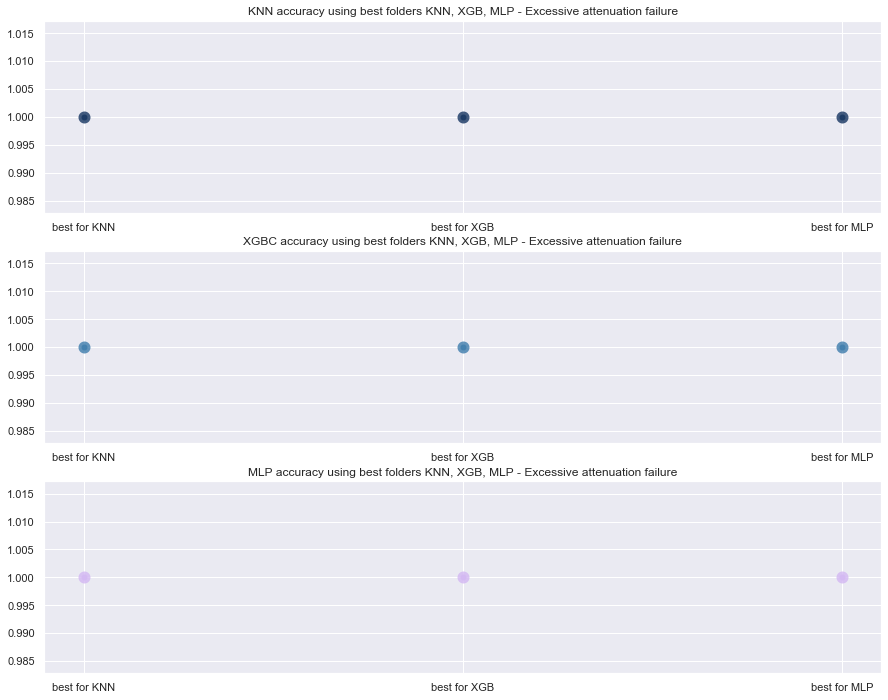

In [470]:
import statistics as st
import decimal 

knn_plot = [st.median(list(knn_accuracy_knn.values())), st.median(list(knn_accuracy_xgbc.values())), st.median(list(knn_accuracy_mlp.values()))]
xgbc_plot = [st.median(list(xgbc_accuracy_knn.values())), st.median(list(xgbc_accuracy_xgbc.values())), st.median(list(xgbc_accuracy_mlp.values()))]
mlp_plot = [st.median(list(mlp_accuracy_knn.values())), st.median(list(mlp_accuracy_xgbc.values())), st.median(list(mlp_accuracy_mlp.values()))]

# Plot accuracy for excessive attenuation failure, testing it over different folders
fig, ax = plt.subplots(3, figsize=(15,12))
colo = ['#163561', '#3E7CAC', '#D3B7F2']

# Plot knn data
ax[0].grid(visible = True)
ax[0].set_title('KNN accuracy using best folders KNN, XGB, MLP - Excessive attenuation failure')
ax[0].scatter(['best for KNN', 'best for XGB', 'best for MLP'], knn_plot, lw=6, color=colo[0], label='KNN accuracy using best folders KNN, XGB, MLP', alpha=.8) 

# Plot xgbc data
ax[1].grid(visible = True)
ax[1].set_title('XGBC accuracy using best folders KNN, XGB, MLP - Excessive attenuation failure')
ax[1].scatter(['best for KNN', 'best for XGB', 'best for MLP'], xgbc_plot, lw=6, color=colo[1], label='XGBC accuracy using best folders KNN, XGB, MLP', alpha=.8) 

# Plot mlp data
ax[2].grid(visible = True)
ax[2].set_title('MLP accuracy using best folders KNN, XGB, MLP - Excessive attenuation failure')
ax[2].scatter(['best for KNN', 'best for XGB', 'best for MLP'], mlp_plot, lw=6, color=colo[2], label='XGBC accuracy using best folders KNN, XGB, MLP', alpha=.8) 


As it was expected, the highest Accuracy is always obtained whenever the best folder for that classifier is used.

e.g. KNN has highest accuracy using the best folder for KNN

e.g. XGBC has highest accuracy using the best folder for XGBC

e.g. MLP has highest accuracy using the best folder for MLP

### **Extra filtering failure (Scenarios 6-7-8)**

In [471]:
knn_accuracy_knn, xgbc_accuracy_knn, mlp_accuracy_knn = evaluate_adjusted_dataset(best_folders_kNN, removed_scenarios = [131, 102, 231, 202, 302, 402, 431, 502, 531])

There are 27 files present
['Scenario_0_monitor_node_1_preamp_lpth_2_1_sp10_w10.dat', 'Scenario_0_monitor_node_1_preamp_lpth_3-1_1_sp10_w10.dat', 'Scenario_0_monitor_node_1_preamp_lpth_3-2_1_sp10_w10.dat', 'Scenario_1_monitor_node_1_preamp_lpth_2_1_sp10_w10.dat', 'Scenario_1_monitor_node_1_preamp_lpth_3-1_1_sp10_w10.dat', 'Scenario_1_monitor_node_1_preamp_lpth_3-2_1_sp10_w10.dat', 'Scenario_2_monitor_node_1_preamp_lpth_2_1_sp10_w10.dat', 'Scenario_2_monitor_node_1_preamp_lpth_3-1_1_sp10_w10.dat', 'Scenario_2_monitor_node_1_preamp_lpth_3-2_1_sp10_w10.dat', 'Scenario_3_monitor_node_1_preamp_lpth_2_1_sp10_w10.dat', 'Scenario_3_monitor_node_1_preamp_lpth_3-1_1_sp10_w10.dat', 'Scenario_3_monitor_node_1_preamp_lpth_3-2_1_sp10_w10.dat', 'Scenario_4_monitor_node_1_preamp_lpth_2_1_sp10_w10.dat', 'Scenario_4_monitor_node_1_preamp_lpth_3-1_1_sp10_w10.dat', 'Scenario_4_monitor_node_1_preamp_lpth_3-2_1_sp10_w10.dat', 'Scenario_5_monitor_node_1_preamp_lpth_2_1_sp10_w10.dat', 'Scenario_5_monitor_node

In [472]:
knn_accuracy_xgbc, xgbc_accuracy_xgbc, mlp_accuracy_xgbc = evaluate_adjusted_dataset(best_folders_XGB, removed_scenarios = [131, 102, 231, 202, 302, 402, 431, 502, 531])

There are 27 files present
['Scenario_0_monitor_node_1_preamp_lpth_2_1_sp10_w10.dat', 'Scenario_0_monitor_node_1_preamp_lpth_3-1_1_sp10_w10.dat', 'Scenario_0_monitor_node_1_preamp_lpth_3-2_1_sp10_w10.dat', 'Scenario_1_monitor_node_1_preamp_lpth_2_1_sp10_w10.dat', 'Scenario_1_monitor_node_1_preamp_lpth_3-1_1_sp10_w10.dat', 'Scenario_1_monitor_node_1_preamp_lpth_3-2_1_sp10_w10.dat', 'Scenario_2_monitor_node_1_preamp_lpth_2_1_sp10_w10.dat', 'Scenario_2_monitor_node_1_preamp_lpth_3-1_1_sp10_w10.dat', 'Scenario_2_monitor_node_1_preamp_lpth_3-2_1_sp10_w10.dat', 'Scenario_3_monitor_node_1_preamp_lpth_2_1_sp10_w10.dat', 'Scenario_3_monitor_node_1_preamp_lpth_3-1_1_sp10_w10.dat', 'Scenario_3_monitor_node_1_preamp_lpth_3-2_1_sp10_w10.dat', 'Scenario_4_monitor_node_1_preamp_lpth_2_1_sp10_w10.dat', 'Scenario_4_monitor_node_1_preamp_lpth_3-1_1_sp10_w10.dat', 'Scenario_4_monitor_node_1_preamp_lpth_3-2_1_sp10_w10.dat', 'Scenario_5_monitor_node_1_preamp_lpth_2_1_sp10_w10.dat', 'Scenario_5_monitor_node

In [473]:
knn_accuracy_mlp, xgbc_accuracy_mlp, mlp_accuracy_mlp = evaluate_adjusted_dataset(best_folders_MLP, removed_scenarios = [131, 102, 231, 202, 302, 402, 431, 502, 531])

There are 27 files present
['Scenario_0_monitor_node_1_preamp_lpth_2_1_sp10_w10.dat', 'Scenario_0_monitor_node_1_preamp_lpth_3-1_1_sp10_w10.dat', 'Scenario_0_monitor_node_1_preamp_lpth_3-2_1_sp10_w10.dat', 'Scenario_1_monitor_node_1_preamp_lpth_2_1_sp10_w10.dat', 'Scenario_1_monitor_node_1_preamp_lpth_3-1_1_sp10_w10.dat', 'Scenario_1_monitor_node_1_preamp_lpth_3-2_1_sp10_w10.dat', 'Scenario_2_monitor_node_1_preamp_lpth_2_1_sp10_w10.dat', 'Scenario_2_monitor_node_1_preamp_lpth_3-1_1_sp10_w10.dat', 'Scenario_2_monitor_node_1_preamp_lpth_3-2_1_sp10_w10.dat', 'Scenario_3_monitor_node_1_preamp_lpth_2_1_sp10_w10.dat', 'Scenario_3_monitor_node_1_preamp_lpth_3-1_1_sp10_w10.dat', 'Scenario_3_monitor_node_1_preamp_lpth_3-2_1_sp10_w10.dat', 'Scenario_4_monitor_node_1_preamp_lpth_2_1_sp10_w10.dat', 'Scenario_4_monitor_node_1_preamp_lpth_3-1_1_sp10_w10.dat', 'Scenario_4_monitor_node_1_preamp_lpth_3-2_1_sp10_w10.dat', 'Scenario_5_monitor_node_1_preamp_lpth_2_1_sp10_w10.dat', 'Scenario_5_monitor_node

**Plotting the median accuracy score of each classifier, retrieved by the best folders exploited** 

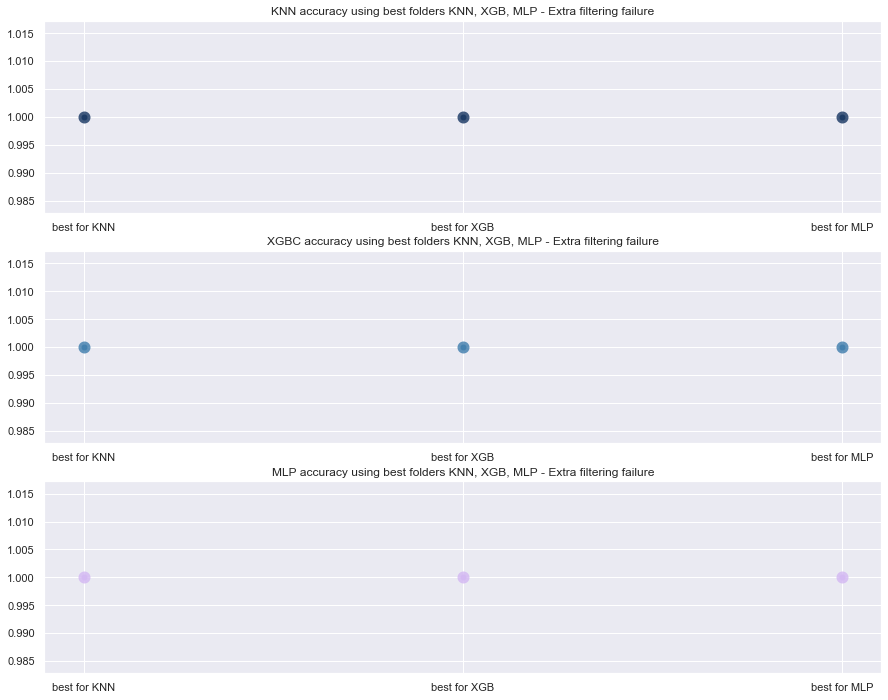

In [474]:
import statistics as st
import decimal 

knn_plot = [st.median(list(knn_accuracy_knn.values())), st.median(list(knn_accuracy_xgbc.values())), st.median(list(knn_accuracy_mlp.values()))]
xgbc_plot = [st.median(list(xgbc_accuracy_knn.values())), st.median(list(xgbc_accuracy_xgbc.values())), st.median(list(xgbc_accuracy_mlp.values()))]
mlp_plot = [st.median(list(mlp_accuracy_knn.values())), st.median(list(mlp_accuracy_xgbc.values())), st.median(list(mlp_accuracy_mlp.values()))]

# Plot accuracy for excessive attenuation failure, testing it over different folders
fig, ax = plt.subplots(3, figsize=(15,12))
colo = ['#163561', '#3E7CAC', '#D3B7F2']

# Plot knn data
ax[0].grid(visible = True)
ax[0].set_title('KNN accuracy using best folders KNN, XGB, MLP - Extra filtering failure')
ax[0].scatter(['best for KNN', 'best for XGB', 'best for MLP'], knn_plot, lw=6, color=colo[0], label='KNN accuracy using best folders KNN, XGB, MLP', alpha=.8) 

# Plot xgbc data
ax[1].grid(visible = True)
ax[1].set_title('XGBC accuracy using best folders KNN, XGB, MLP - Extra filtering failure')
ax[1].scatter(['best for KNN', 'best for XGB', 'best for MLP'], xgbc_plot, lw=6, color=colo[1], label='XGBC accuracy using best folders KNN, XGB, MLP', alpha=.8) 

# Plot mlp data
ax[2].grid(visible = True)
ax[2].set_title('MLP accuracy using best folders KNN, XGB, MLP - Extra filtering failure')
ax[2].scatter(['best for KNN', 'best for XGB', 'best for MLP'], mlp_plot, lw=6, color=colo[2], label='XGBC accuracy using best folders KNN, XGB, MLP', alpha=.8) 

## **Optional part-Advanced topics**

### **EXplainable Artificial Intelligence (XAI)**

**Create a Random Forest Classifier and use LIME and SHAP explainers, to explain each features interpretation in the model**

In [475]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.metrics as mt
from sklearn.ensemble import RandomForestClassifier

#XAI-related packages: we will use two XAI frameworks: LIME and SHAP
import lime 
import lime.lime_tabular
import shap 
import shap.plots

In [476]:
#Retrieve the available files for analysis
path = r'./' + random_best_folder + '/'
list_of_adjusted_files = retrieve_files(path)

# Create datasets, append GroundTruth & normalizes the feature values per light path per scenario
dataset, X, Y = create_dataset(list_of_adjusted_files, path, skip=False)

# Create also a normalized version of the data
normalized_X = normalize_dataset(X)
    
#Retrieve the available files for analysis
path = r'./' + foldername + '/'
list_of_adjusted_files = retrieve_files(path)

# Create datasets, append GroundTruth & normalizes the feature values per light path per scenario
dataset, X, Y = create_dataset(list_of_adjusted_files, path, skip=False)

# Create also a normalized version of the data
normalized_X = normalize_dataset(X)

y = dataset['GroundTruth'].to_numpy()

# Find the number of distinct labels and make a list of distinct labels for later use
n_label = len(set(y))
labels = list(set(y))

#define test percetange
test_percentage = 0.2

#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_percentage,random_state=36, stratify=y, shuffle=True)
X_train = X_train.values
X_test = X_test.values

#set hyperparameters 
Best_trees = 290 
Best_criterion = "entropy"

#train model
rf = RandomForestClassifier(n_estimators=Best_trees, criterion=Best_criterion, class_weight='balanced')
rf = rf.fit(X_train, y_train)

#predict class of failure. y_predicted is an array of all predictions while y_test is the ground truth
y_predicted = rf.predict(X_test)


np.set_printoptions(precision=5)
print("Accuracy: ", mt.accuracy_score(y_test, y_predicted))
print("Precision: ", mt.precision_score(y_test, y_predicted, labels=labels, average=None))
print("Recall: ", mt.recall_score(y_test, y_predicted, labels=labels, average=None))
print("F1-score: ",mt.recall_score(y_test, y_predicted, labels=labels, average=None))


There are 27 files present
['Scenario_0_monitor_node_1_preamp_lpth_2_1_sp10_w30.dat', 'Scenario_0_monitor_node_1_preamp_lpth_3-1_1_sp10_w30.dat', 'Scenario_0_monitor_node_1_preamp_lpth_3-2_1_sp10_w30.dat', 'Scenario_1_monitor_node_1_preamp_lpth_2_1_sp10_w30.dat', 'Scenario_1_monitor_node_1_preamp_lpth_3-1_1_sp10_w30.dat', 'Scenario_1_monitor_node_1_preamp_lpth_3-2_1_sp10_w30.dat', 'Scenario_2_monitor_node_1_preamp_lpth_2_1_sp10_w30.dat', 'Scenario_2_monitor_node_1_preamp_lpth_3-1_1_sp10_w30.dat', 'Scenario_2_monitor_node_1_preamp_lpth_3-2_1_sp10_w30.dat', 'Scenario_3_monitor_node_1_preamp_lpth_2_1_sp10_w30.dat', 'Scenario_3_monitor_node_1_preamp_lpth_3-1_1_sp10_w30.dat', 'Scenario_3_monitor_node_1_preamp_lpth_3-2_1_sp10_w30.dat', 'Scenario_4_monitor_node_1_preamp_lpth_2_1_sp10_w30.dat', 'Scenario_4_monitor_node_1_preamp_lpth_3-1_1_sp10_w30.dat', 'Scenario_4_monitor_node_1_preamp_lpth_3-2_1_sp10_w30.dat', 'Scenario_5_monitor_node_1_preamp_lpth_2_1_sp10_w30.dat', 'Scenario_5_monitor_node

### LIME explainer

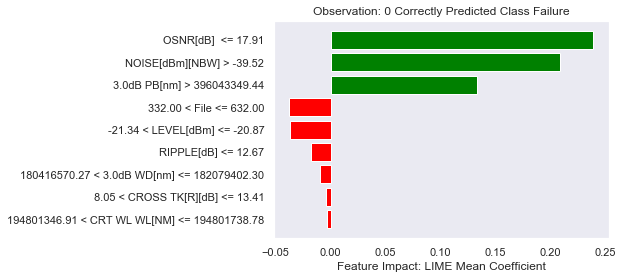

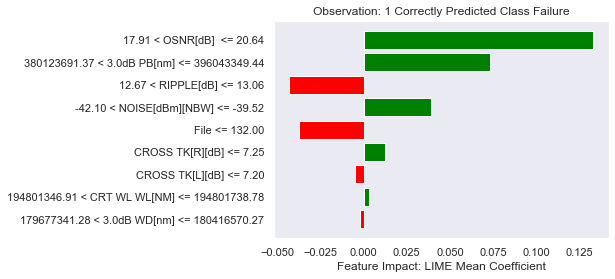

In [477]:
#get names of features (columns from data set) and set class names 
f = X.columns.values
classfullname = ['No failure', 'Failure']

#create LIME tabular explainer with 4 arguments: 
# 1) train data X_train that will be used to fit the blackbox model
# 2) features' names f (for visualization purposes)
# 3) name of classes (for visualization purposes)
# 4) mode (classification or regression, we are dealing with a classification problem)

explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=f, class_names=classfullname, mode='classification')


#to perform local explanations, we will use the method 'explain_instance'. 
#explain_instance takes 4 arguments: 
    # 1) data point to explain X_test[n], 
    # 2) blackbox model prediction function rf.predict_proba
    # 3) number of features to visualize in the output figure 
    # 4) set of labels (we will define a labels array for this purpose)


# 1) for a given value of n, X_test[n] represents the test point to explain and the 1st argument to pass to explain_instance
# 2) rf.predict_proba represents the second argument to pass to explain_instance
# 3) num_features=15 to visualize on output figure the most important 9 features, this is the 3rd argument to pass to explain_instance
labels  = [0, 1] # 4) 2 arguments to pass to explain_instance


N = 2 #number of test data points to explain

# Let's explain 2 points in the test set:   
for n in range(N):   
    exp = explainer.explain_instance(X_test[n], rf.predict_proba, num_features=9, labels=labels) 
    #exp now represents the explanation of test data point X_test[n]
    
    #draw exp as a pyplot figure. Pass exp.as_pyplot_figure the predicted class
    exp.as_pyplot_figure(int(y_predicted[n])) 
   
    #check if correct or wrong prediction and set appropriate plot title (using 'blackboxprediction' variable)
    if int(y_test[n]) == int(y_predicted[n]):
        blackboxprediction = 'Correctly Predicted Class %s' % exp.class_names[int(y_predicted[n])] 
    else: 
        blackboxprediction = 'Wrongly Predicted Class %s' % exp.class_names[int(y_predicted[n])]    
    #set a title to figure
    title = "Observation: " + str(n) + ' ' + blackboxprediction 
    plt.title(title) 
    #set x-axis label and plot figure
    plt.xlabel('Feature Impact: LIME Mean Coefficient')
    plt.grid()
    plt.show()


In the above illustrated plots have 2 aspects to be read on
- The biggest the bar next to the feature, the highest the importance for the model
- In case the bar is heading towards the right and it is green, it means that the feature was interpreted properly. Else it has been misinterpreted

### SHAP explainer

In [478]:
#set number of shap points to consider with SHAP, we can consider the whole dataset 
shappoints = 2500

#create and initialize explainer, we use TreeExplainer and pass the rf classifier as an argument
explainer_shap = shap.TreeExplainer(rf)

#Calculating the SHAP values by using shap_values method. It takes training data as an argument
shap_values = explainer_shap.shap_values(X[:shappoints])

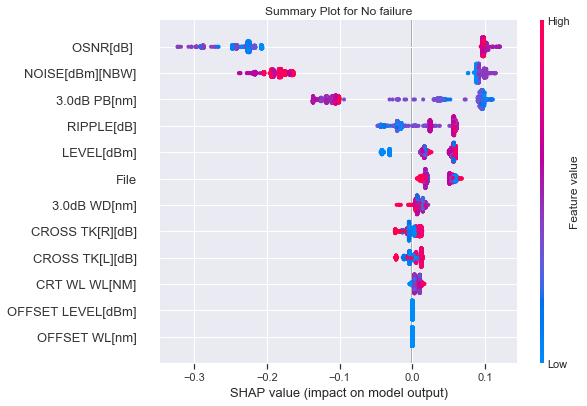

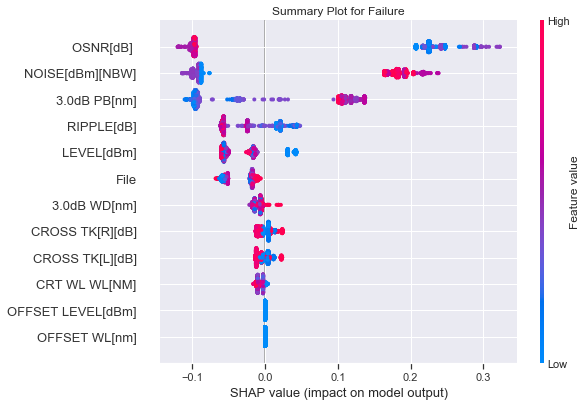

In [479]:
#Iterate over labels (classes) and plot SHAP's summary plot of each label using shap.summary_plot method
#method takes shap_values of the class, data set (from this SHAP gets features' values) and features names 
#in addition to the number of features to display
#we use show = False so the figure is not directly plotted so we can add a unique title to it in a next step
for classitr in range(n_label):
    shap.summary_plot(shap_values[classitr], features=X[:shappoints],feature_names=f, show = False, max_display=18)
    #set title and show
    title = 'Summary Plot for ' + str(classfullname[classitr])
    plt.title(title)
    plt.show()


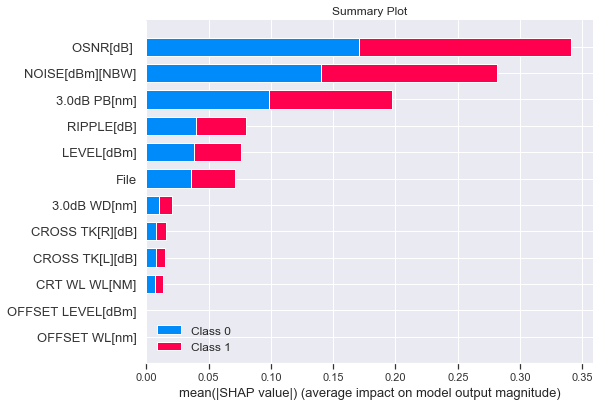

In [480]:
#Plot the overall summary plot (for all classes) using summary_plot method
#We passed the method 4 arguments: 1) calculated SHAP values, 2) feature names, 3) show = False to not directly
#plot the figure and 4) max_display to specify the number of features to display in figure
shap.summary_plot(shap_values, feature_names=f, show = False, max_display=18)
plt.title("Summary Plot")
plt.show()